In [1]:
from modules import (SVDCompressedLinear, TTCompressedLinear,
                                       factorize, make_contraction)

Working dir: /home/seleznyov/repos/compression/notebooks/layer_compress_classifier


In [2]:
import torch
weights = torch.rand(768, 3072)

## Create layer

In [3]:
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer)

axlen = 512
query_maxlen = 512
doc_maxlen = 512
dim = 128
similarity = 'cosine'

config = AutoConfig.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        use_auth_token=None)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

bert = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',
        config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [4]:
fc_w = bert.bert.encoder.layer[0].intermediate.dense

In [5]:
type(fc_w.weight.data.T)

torch.Tensor

In [6]:
rank = 5  # Uniform TT-rank.
shape = (
(12, 2, 2, 16),  # Row dimention.
(32, 3, 2, 16),  # Column dimention.
)

layer = TTCompressedLinear.from_linear(fc_w, shape=shape, rank=rank)

core shape1 (1, 384, 5)
core shape1 (5, 6, 5)
core shape1 (5, 4, 5)
core shape1 (5, 256, 1)


In [7]:
s_values=layer.get_proper_rank(matrix=fc_w.weight.data.T) 

rank, shape (1, 5, 5, 5, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 5, 5, 5, 1), (1, 5, 5, 5, 1), (1, 5, 5, 5, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


## Get colbert weights

# encoder

In [8]:
#a = TTLinear(in_features = 768, out_features = 3072, ranks =[72, 72, 72] , input_dims = [12, 2, 2 ,16], output_dims= [32, 2, 3, 16])

In [9]:
fc_w = colbert.bert.encoder.layer[1].intermediate.dense

NameError: name 'colbert' is not defined

In [ ]:
a.set_weight(fc_w.weight)

In [ ]:
a = TTLinear(in_features = 768, out_features = 3072, ranks =[72, 72, 72] , input_dims = [6, 4, 4 ,8], output_dims= [16, 4, 6, 8])

In [ ]:
fc_w = colbert.bert.encoder.layer[0].intermediate.dense

In [ ]:
a.set_weight(fc_w.weight)

In [ ]:
import matplotlib.pyplot as plt
rank = 72  # Uniform TT-rank.
shape = (
(12, 2, 2, 16),  # Row dimention.
(32, 3, 2, 16),  # Column dimention.
)

layer = TTCompressedLinear.from_linear(fc_w, shape=shape, rank=rank)


for ind, elem in enumerate(bert.bert.encoder.layer):
    print ("layer ", ind)
    fc_w = bert.bert.encoder.layer[ind].intermediate.dense
    s_values=layer.get_proper_rank(matrix=fc_w.weight.data.T) 
    for elem in s_values:
        plt.plot(elem[:100])
        plt.show()
    print ("\n")

In [ ]:
import matplotlib.pyplot as plt
rank = 72  # Uniform TT-rank.
shape = (
(12, 2, 2, 16),  # Row dimention.
(32, 3, 2, 16),  # Column dimention.
)

layer = TTCompressedLinear.from_linear(fc_w, shape=shape, rank=rank)


for ind, elem in enumerate(bert.bert.encoder.layer):
    print ("layer ", ind)
    fc_w = colbert.bert.encoder.layer[ind].intermediate.dense
    s_values=layer.get_proper_rank(matrix=fc_w.weight.data.T) 
    for elem in s_values:
        plt.plot(elem[:100])
        plt.show()
    print ("\n")

## decoder

In [ ]:
#a = TTLinear(in_features = 3072, out_features = 768, ranks =[72, 72, 72] , input_dims = [12, 2, 2, 16], output_dims= [32, 3, 2, 16])

In [41]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 7
plt.rcParams["figure.dpi"] = 120

COMPRESS_DIR = "compress"
KEEP_DIR = "keep"


def make_dataset_bert(bert, part, layer_to_compress):
    rank = 72
    shape = ((12, 2, 2, 16), (32, 3, 2, 16))
    
    fc_w = bert.bert.encoder.layer[0].intermediate.dense
    compressed_layer = TTCompressedLinear.from_linear(fc_w, shape=shape, rank=rank)

    list_of_data = []
    
    
    for layer_idx, layer in enumerate(tqdm(bert.bert.encoder.layer)):
        unfoldings_singular_values = compressed_layer.get_proper_rank(
            matrix=getattr(layer, part).dense.weight.data.T)
        
        
        for mode, s_values in enumerate(unfoldings_singular_values):
            path = f"images/{COMPRESS_DIR if layer_idx in layer_to_compress else KEEP_DIR}/bert_{part}_layer_{layer_idx}.png"
            plt.plot(s_values)
            plt.title(f"Bert, layer {layer_idx}, {part}")
            plt.xlabel("Index of singular number")
            plt.ylabel("Value of singular number")
            plt.savefig(path)
            plt.show()
            
            
            list_of_data.append({
                "model_and_part": f"bert_{part}",
                "layer_idx": layer_idx,
                "s_values": s_values.numpy(),
                "unfolding_mode": mode,
                "keep": True if layer_idx in layer_to_compress else False,
            })
    return pd.DataFrame(list_of_data)

core shape1 (1, 384, 72)
core shape1 (72, 6, 72)
core shape1 (72, 4, 72)
core shape1 (72, 256, 1)


  0%|                                                                                                                        | 0/12 [00:00<?, ?it/s]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


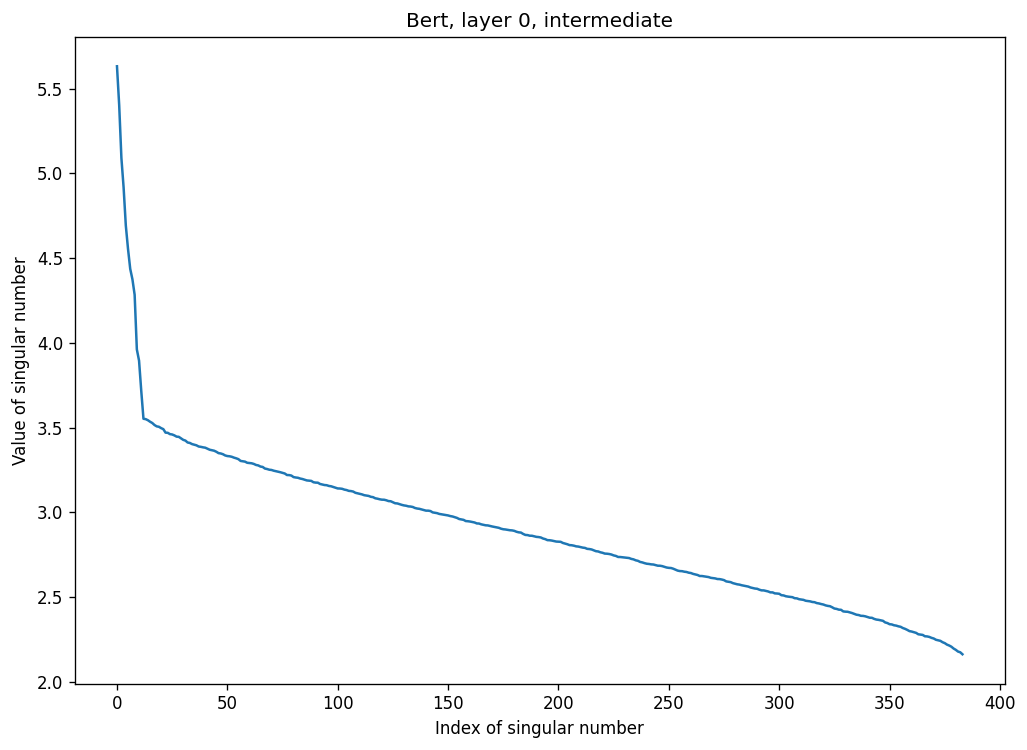

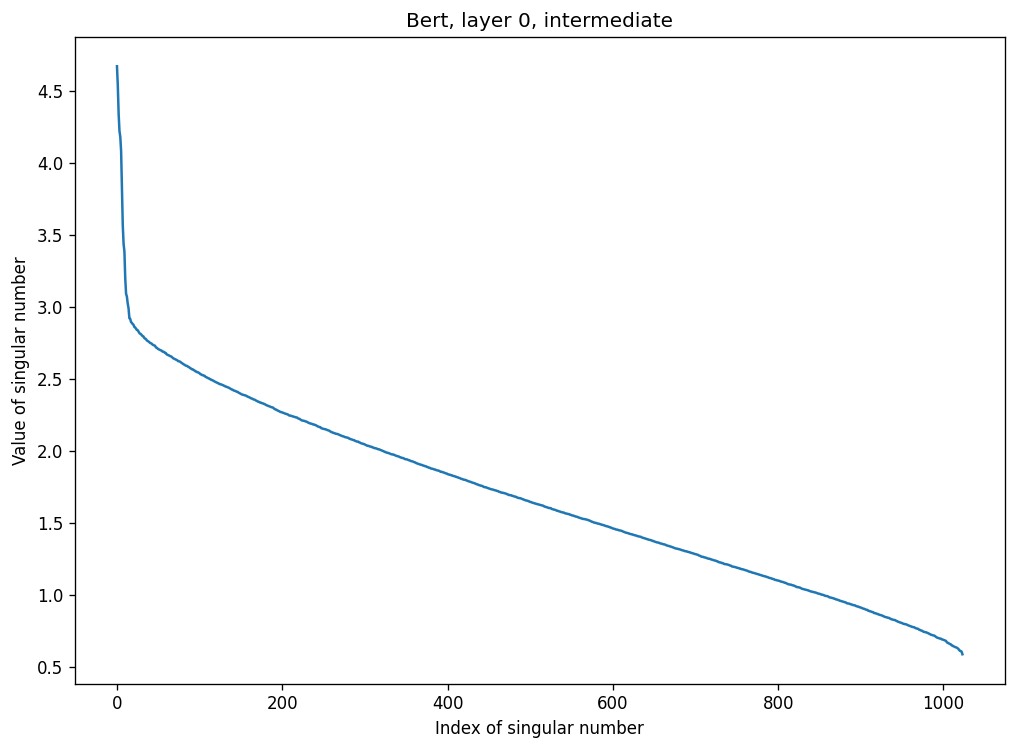

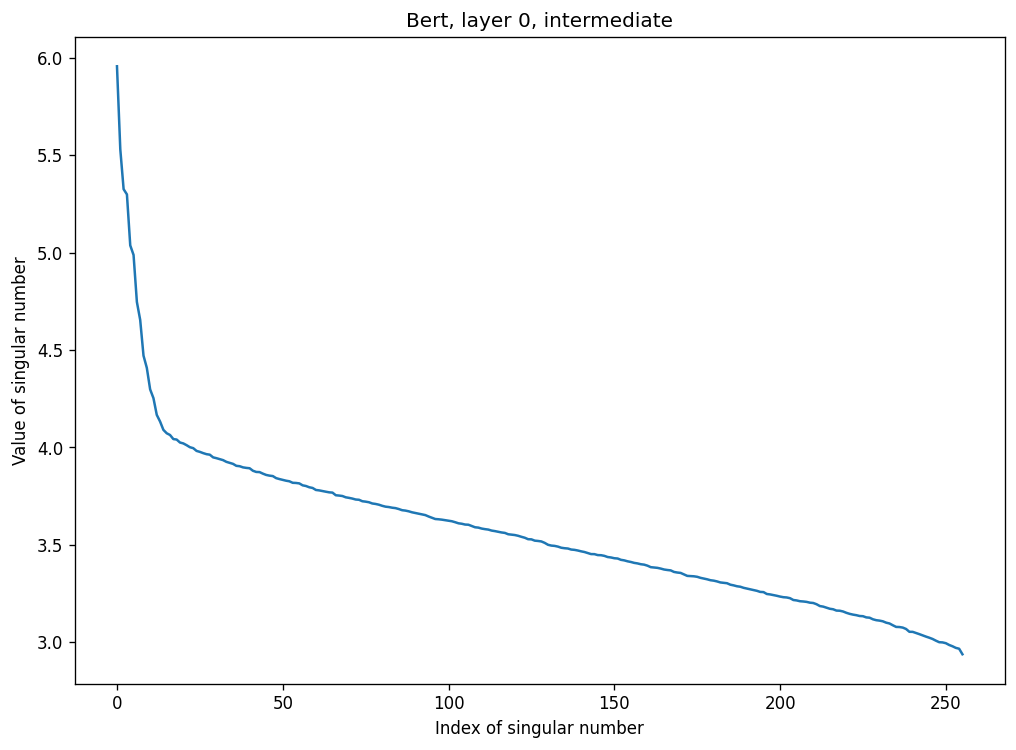

  8%|█████████▎                                                                                                      | 1/12 [00:01<00:18,  1.72s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


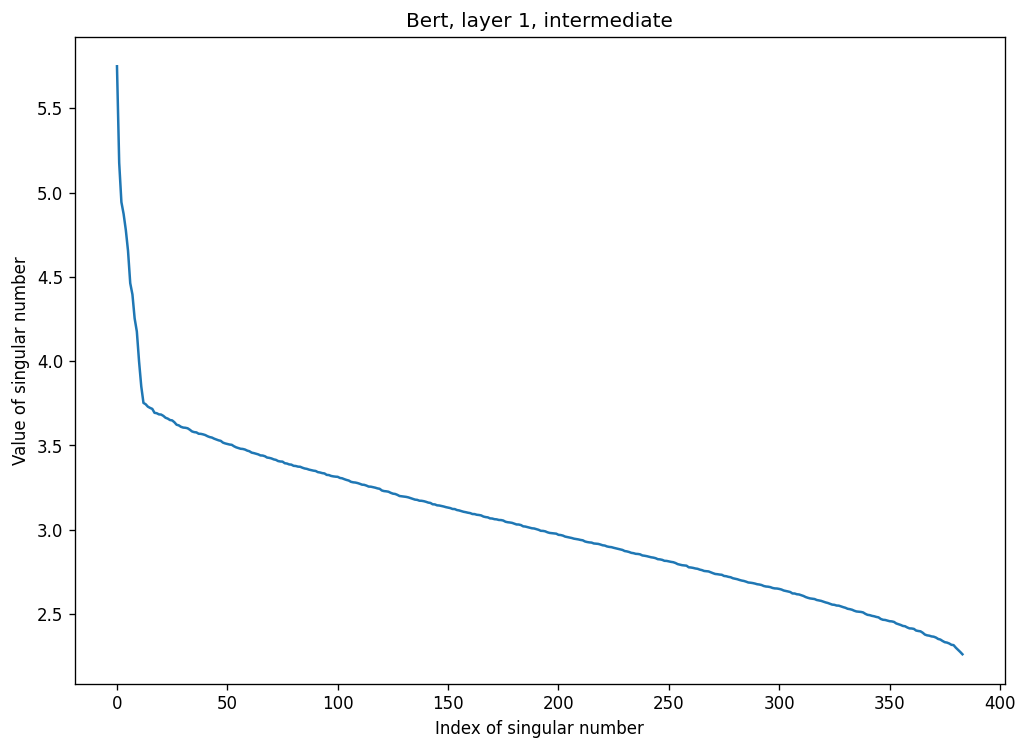

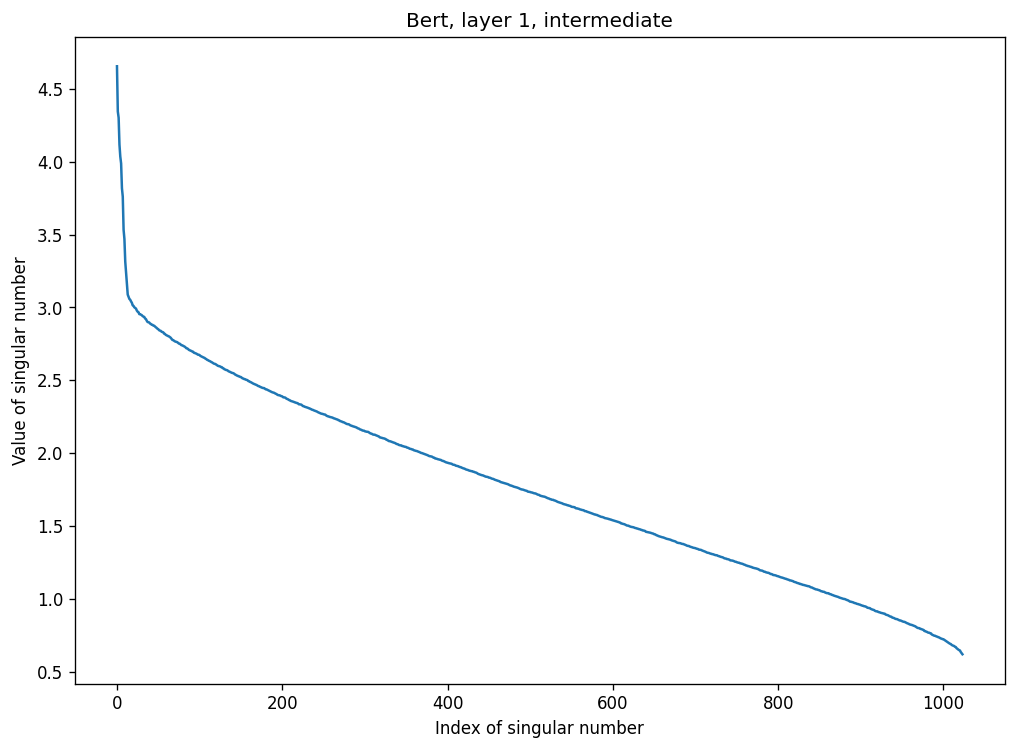

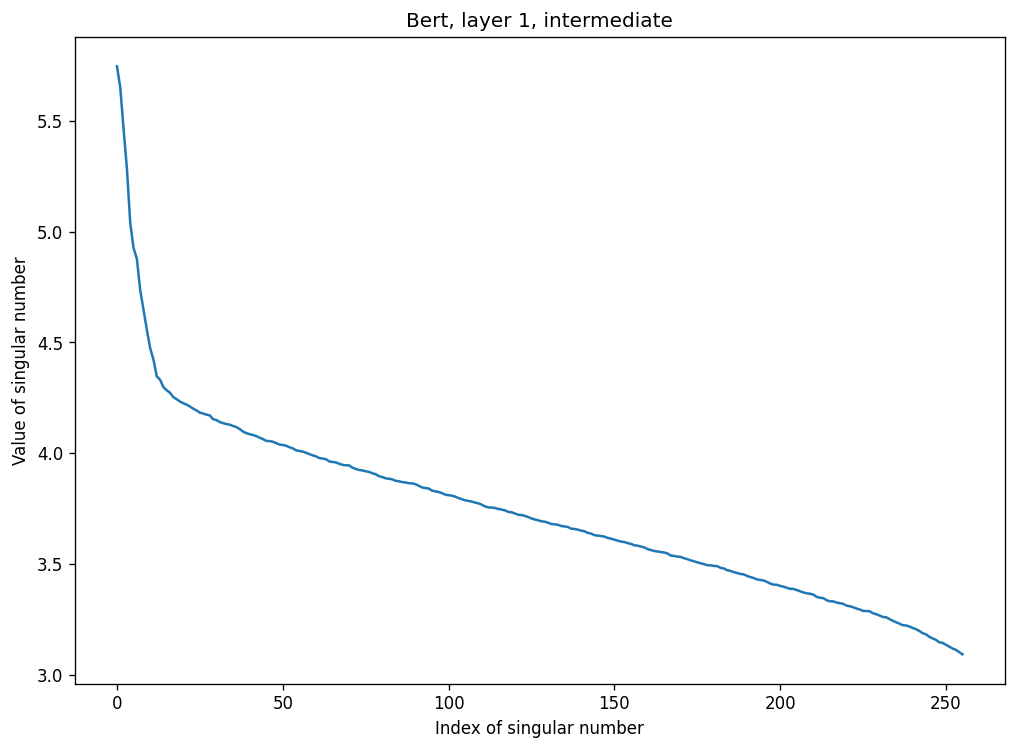

 17%|██████████████████▋                                                                                             | 2/12 [00:03<00:16,  1.70s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


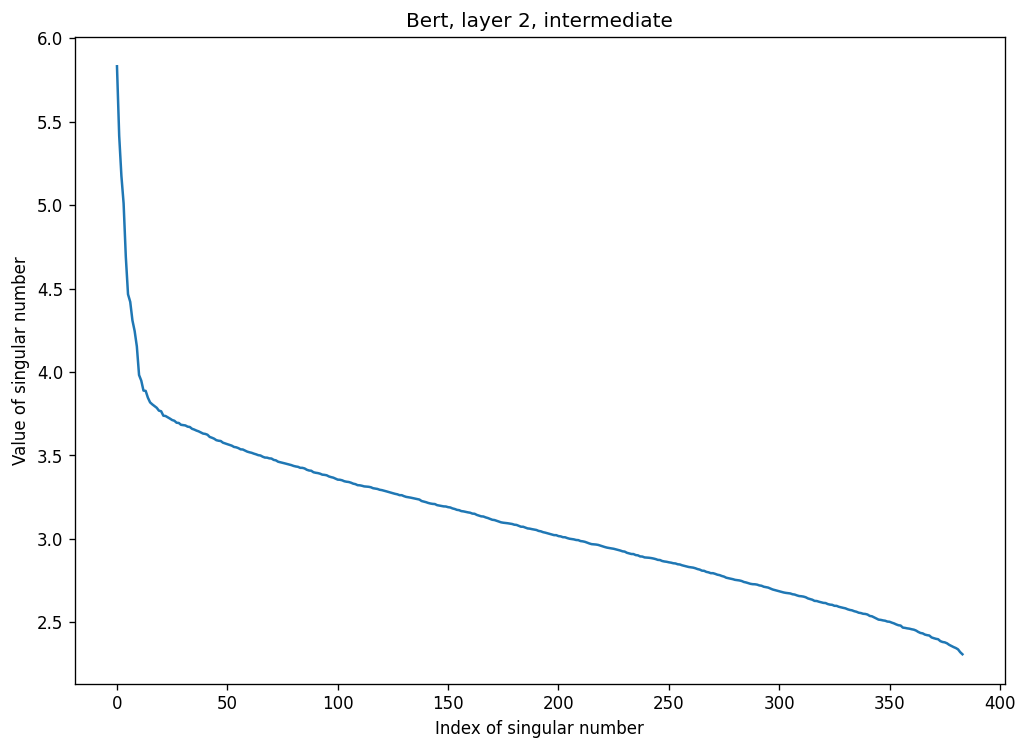

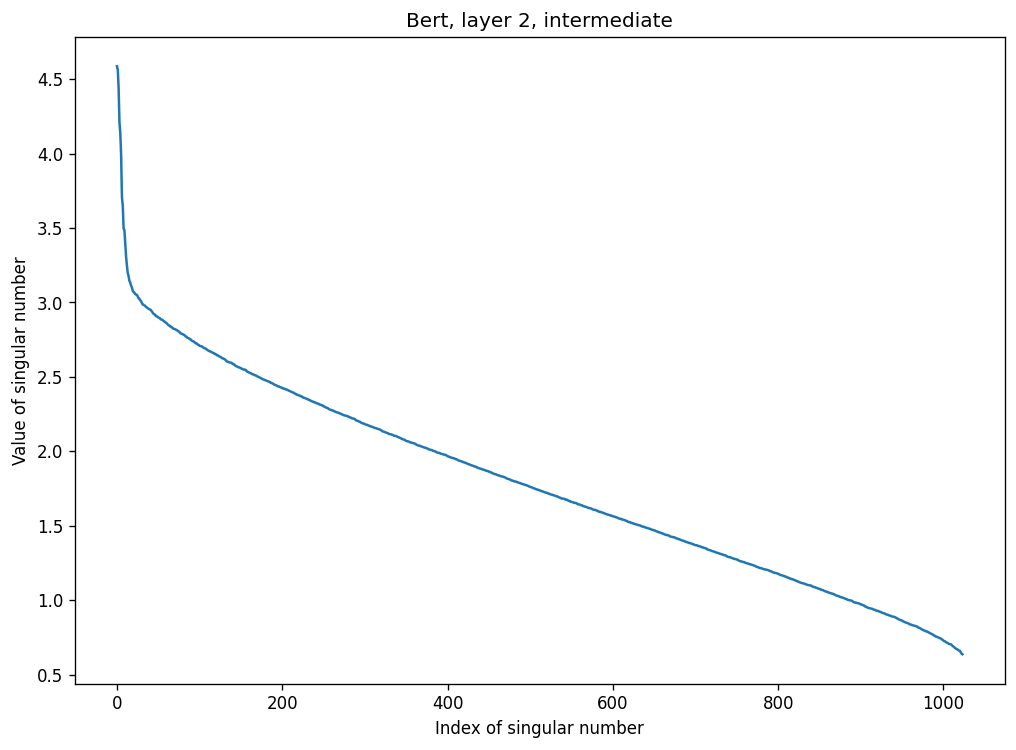

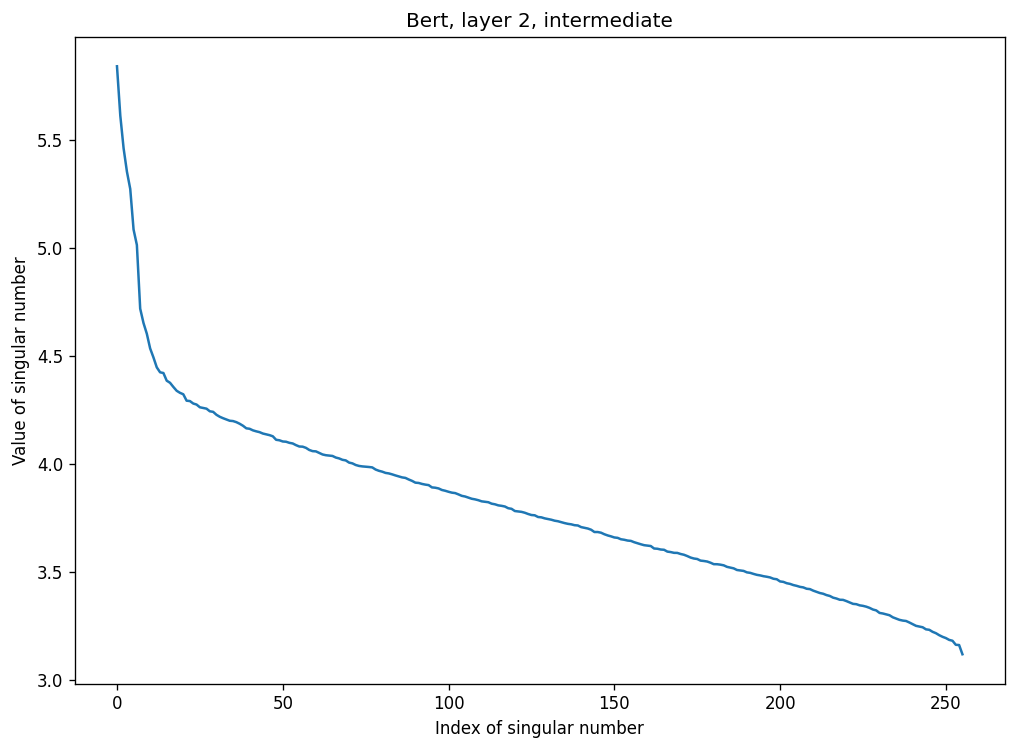

 25%|████████████████████████████                                                                                    | 3/12 [00:05<00:15,  1.73s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


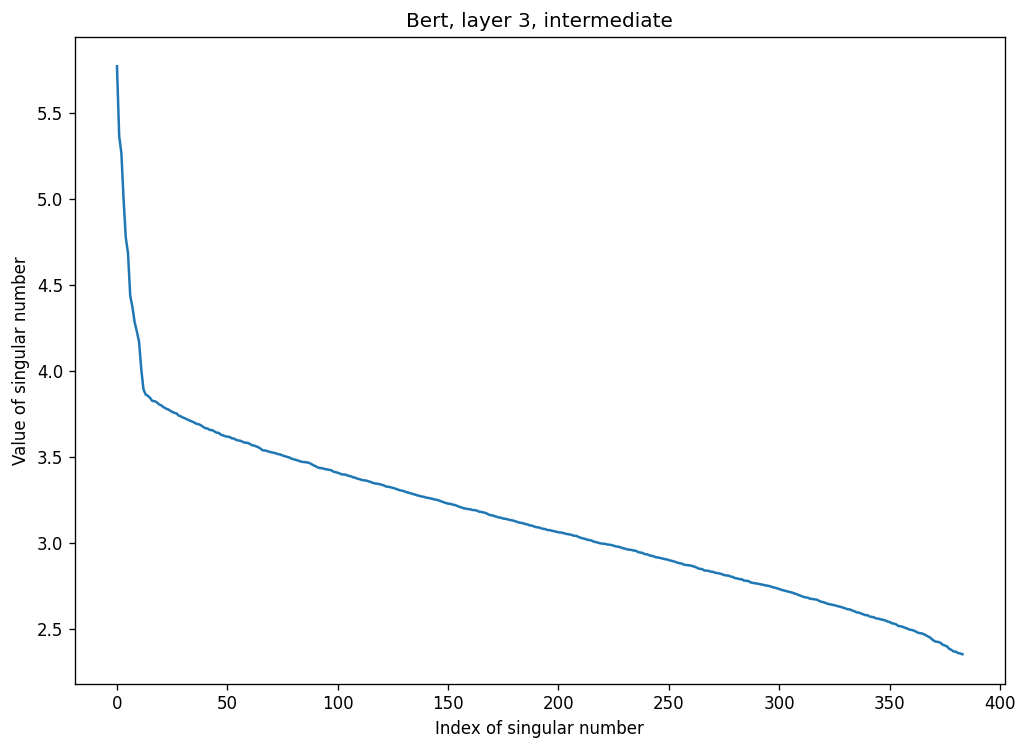

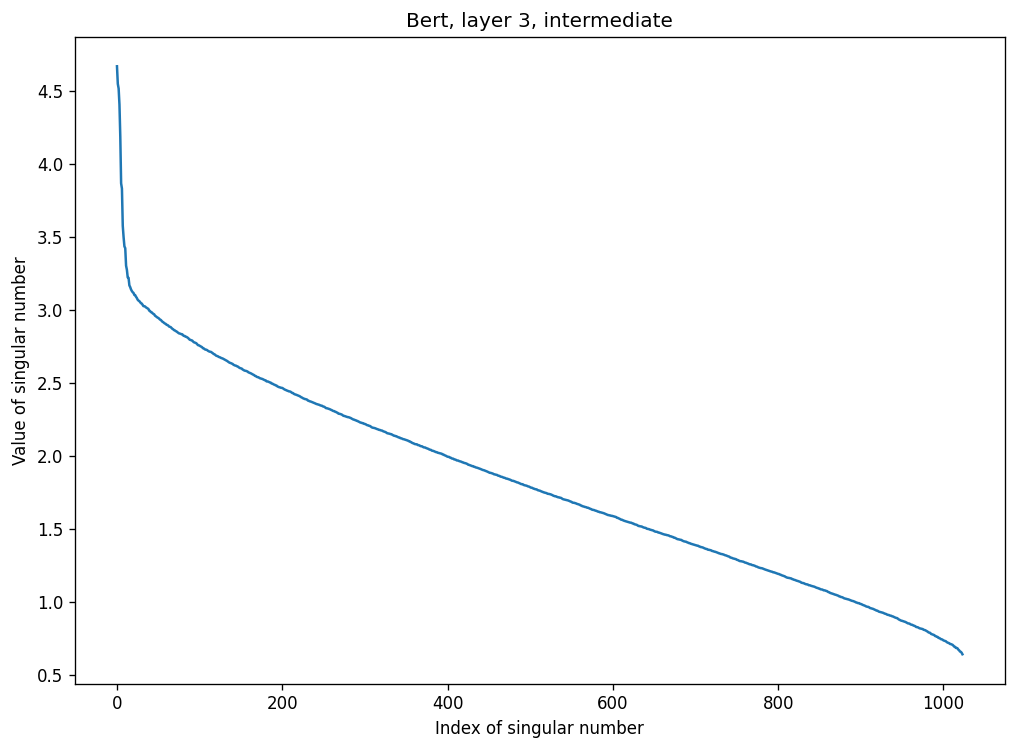

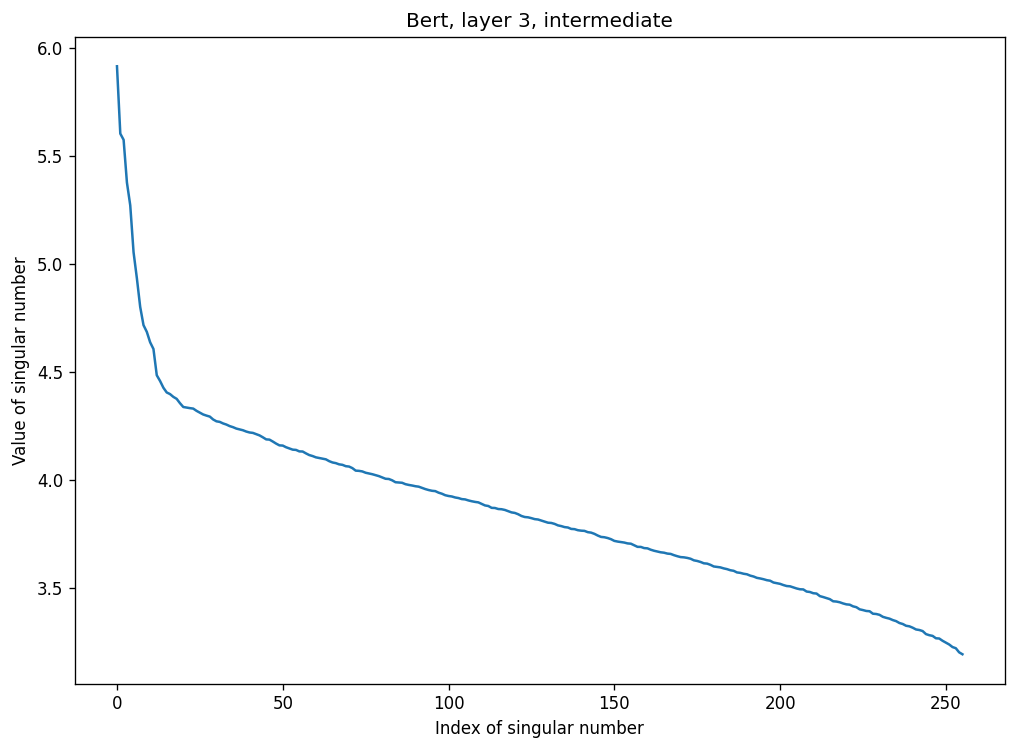

 33%|█████████████████████████████████████▎                                                                          | 4/12 [00:07<00:14,  1.81s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


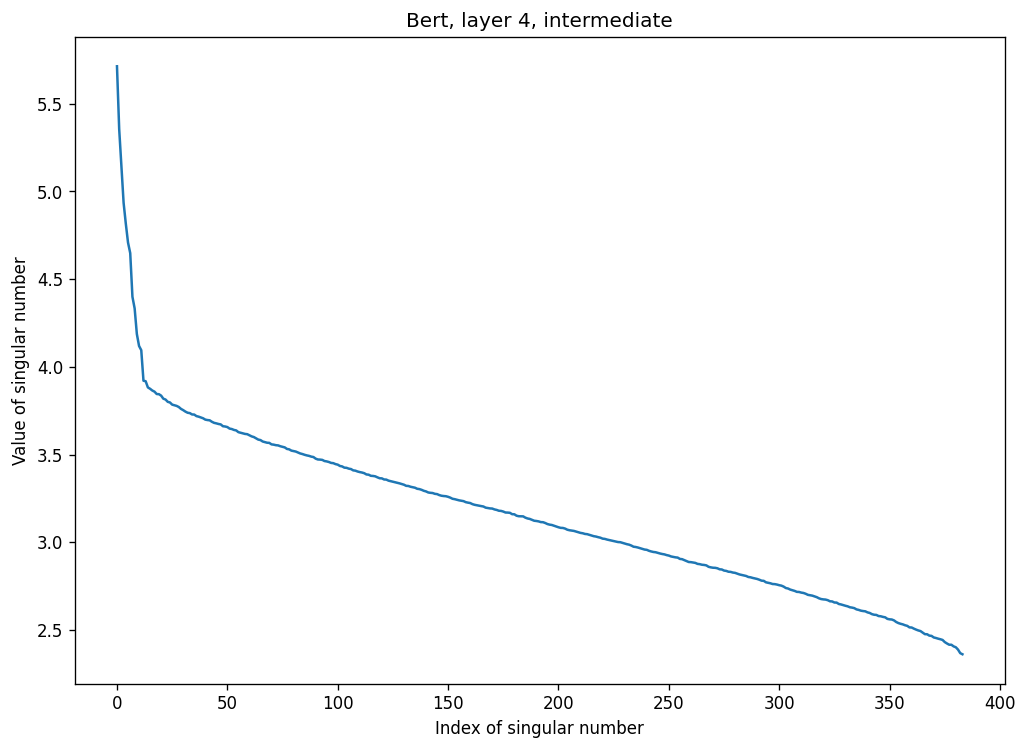

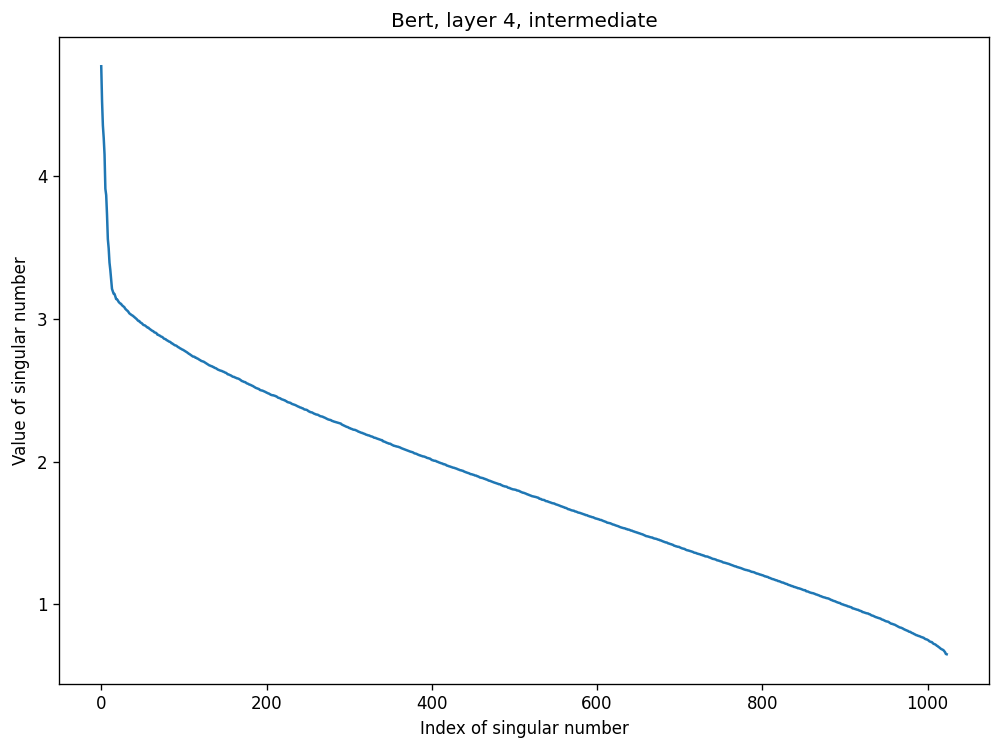

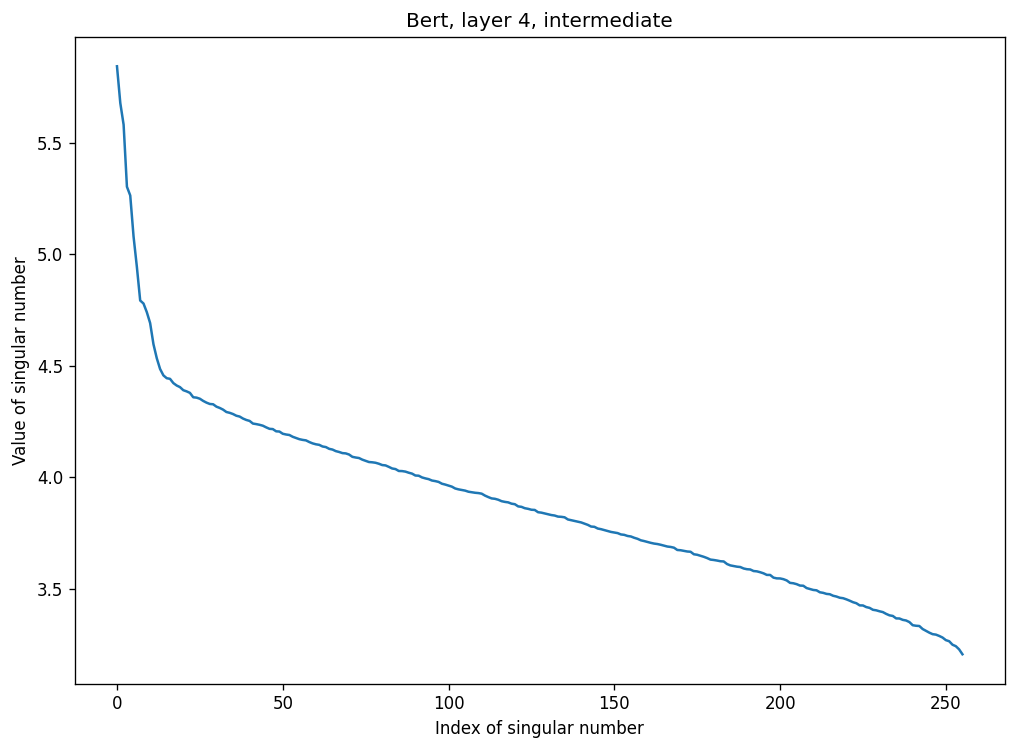

 42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:08<00:12,  1.78s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


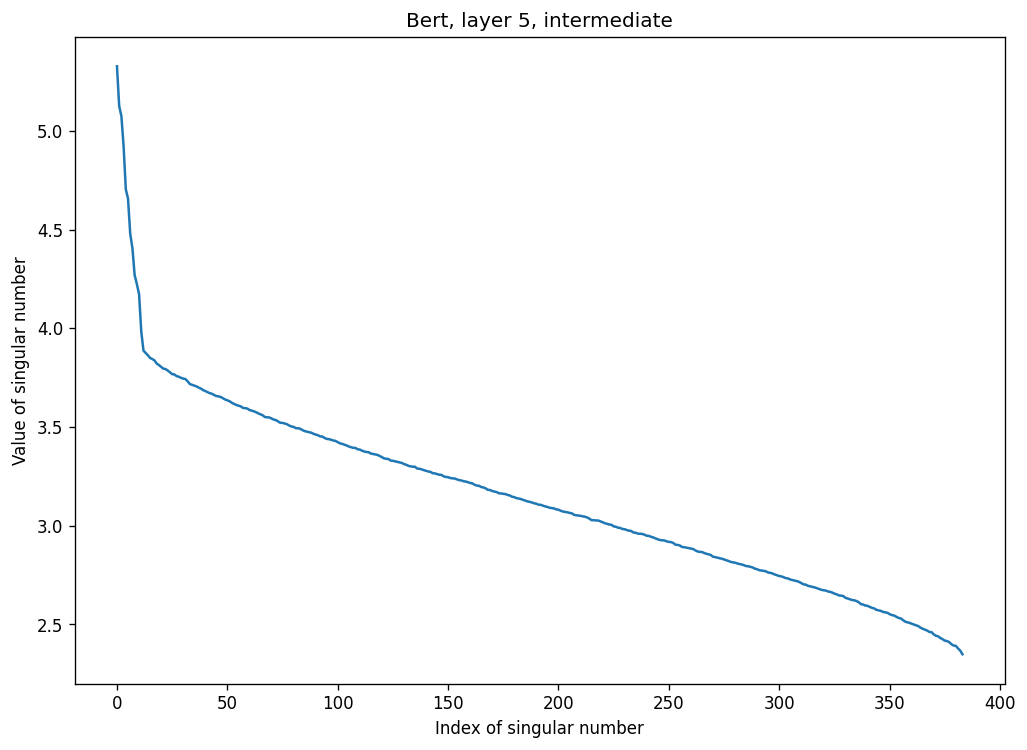

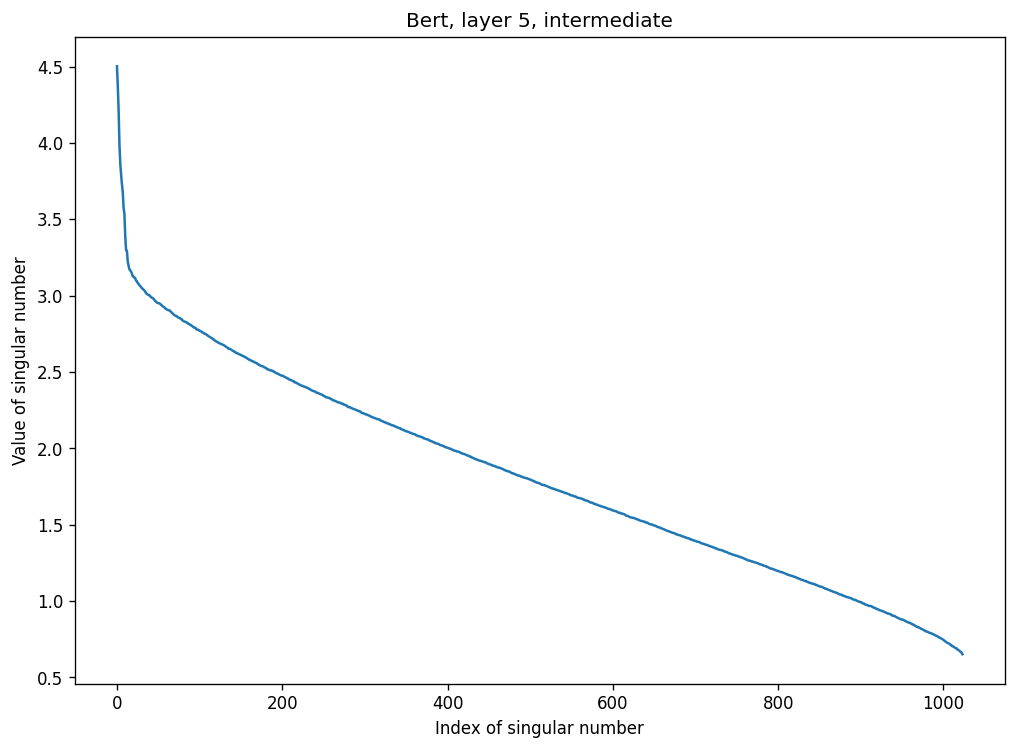

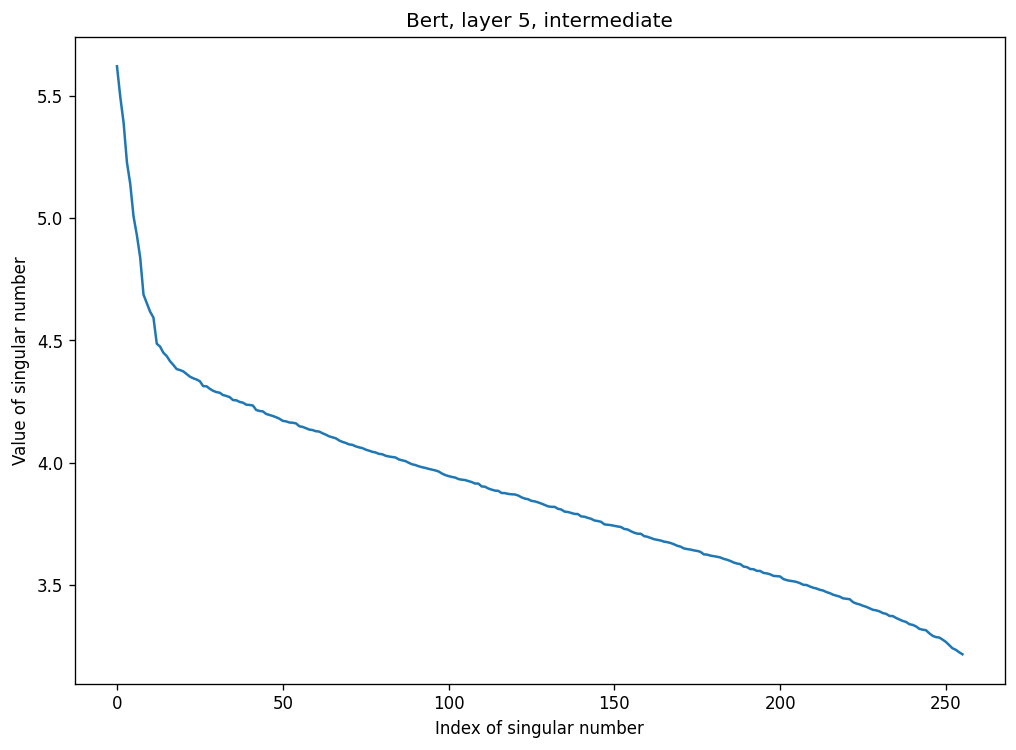

 50%|████████████████████████████████████████████████████████                                                        | 6/12 [00:10<00:10,  1.76s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


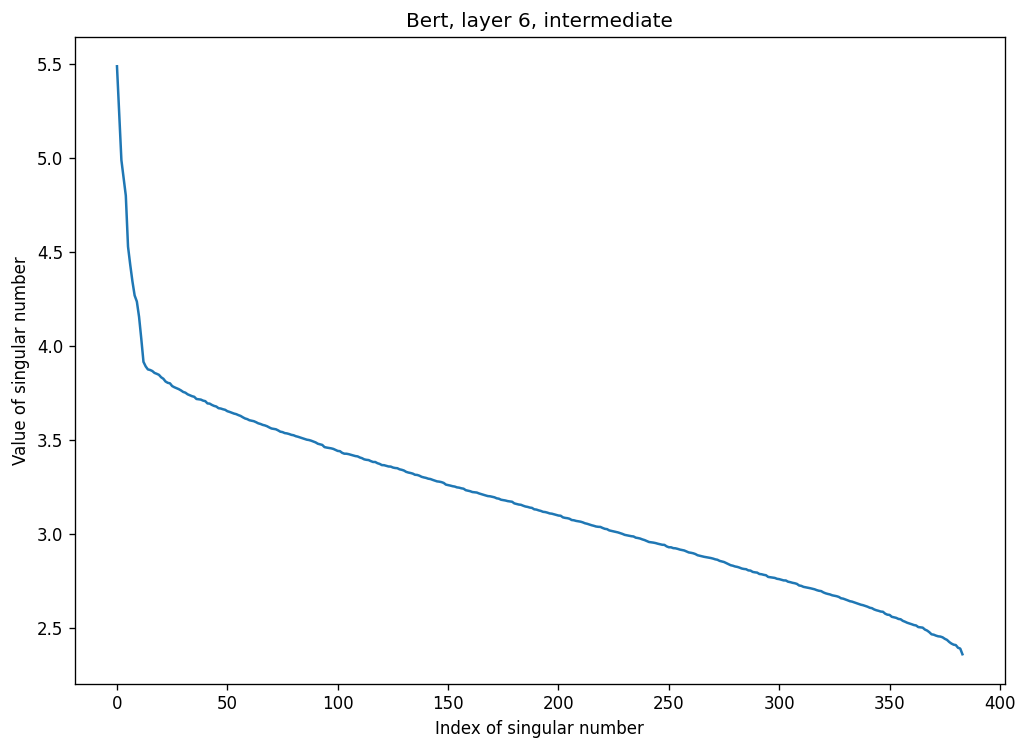

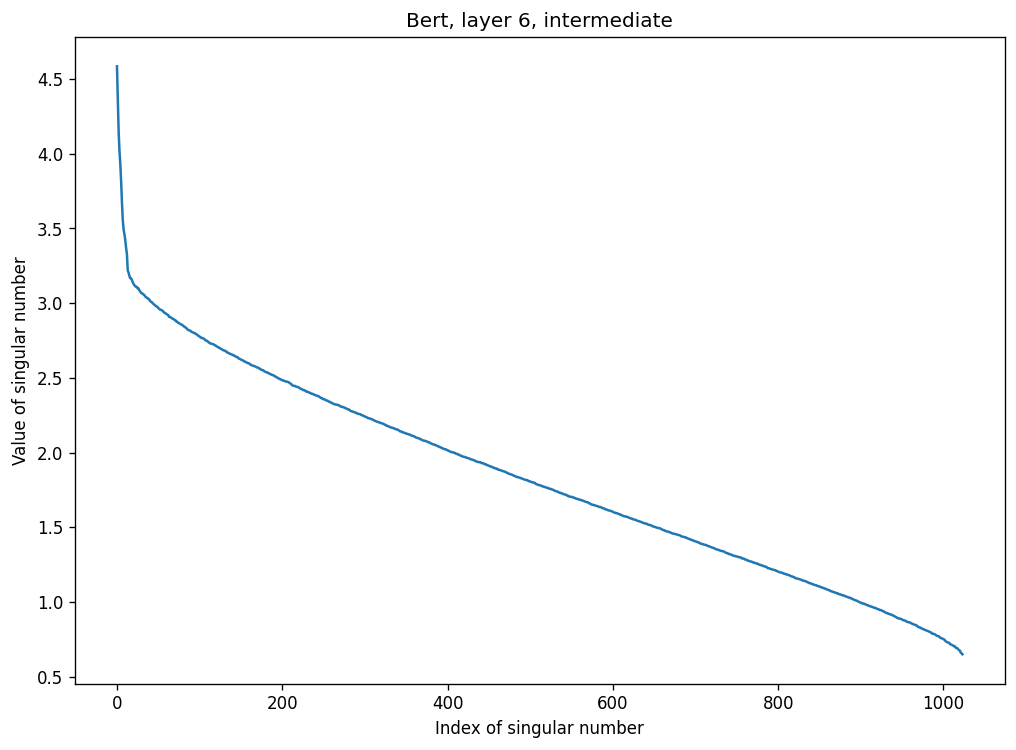

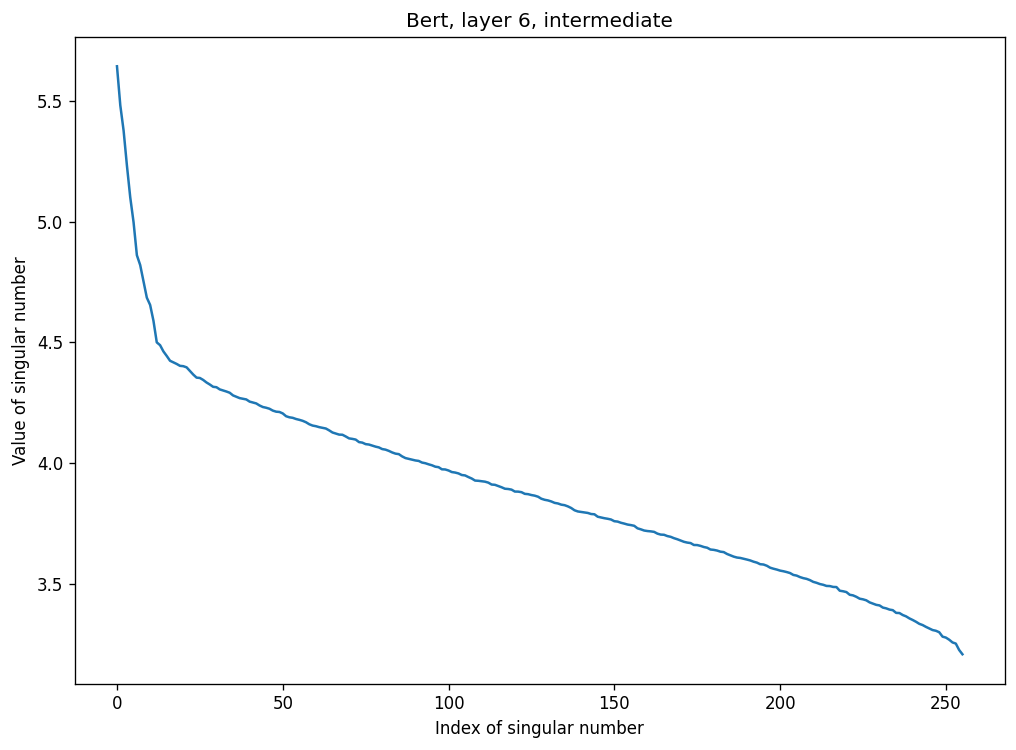

 58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:12<00:08,  1.74s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


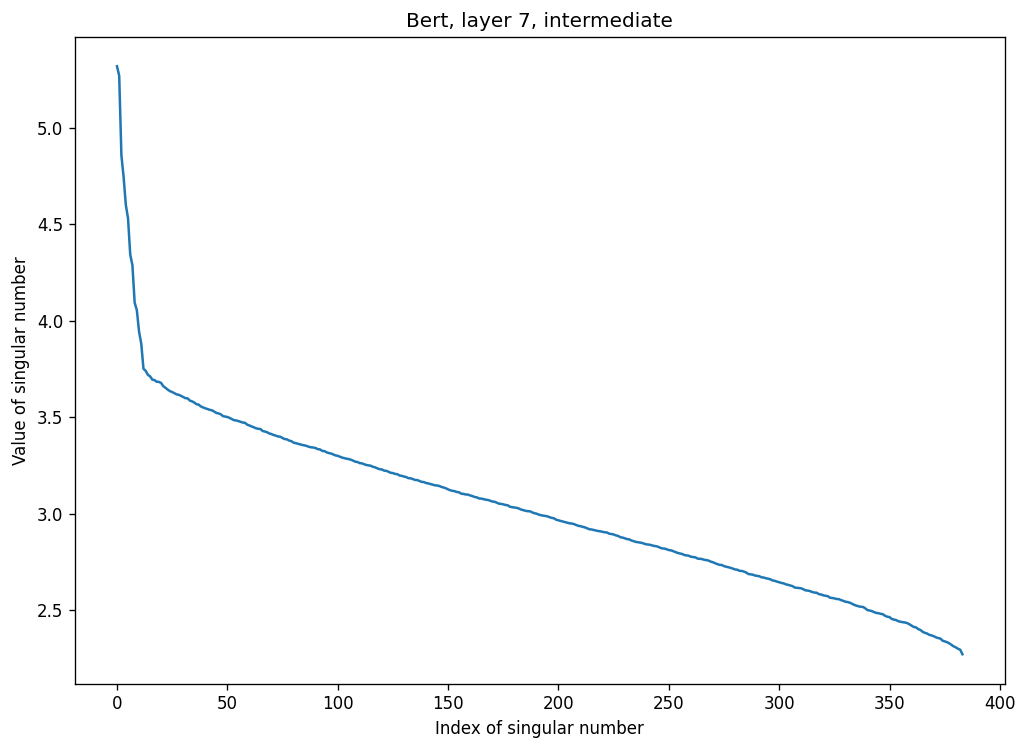

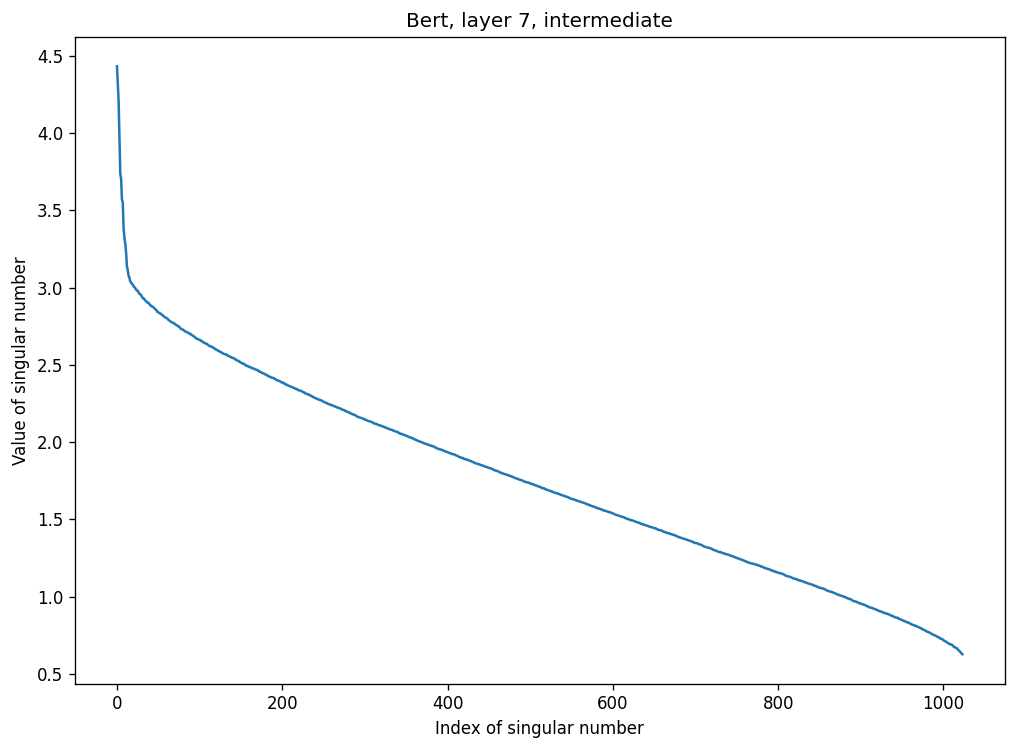

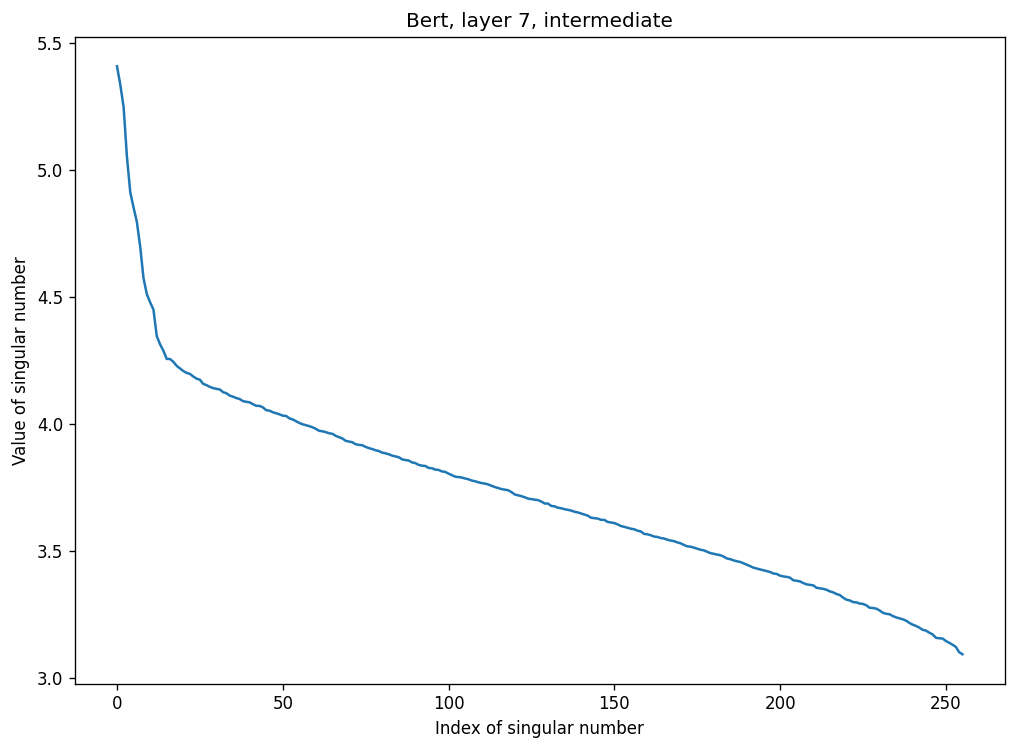

 67%|██████████████████████████████████████████████████████████████████████████▋                                     | 8/12 [00:13<00:06,  1.72s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


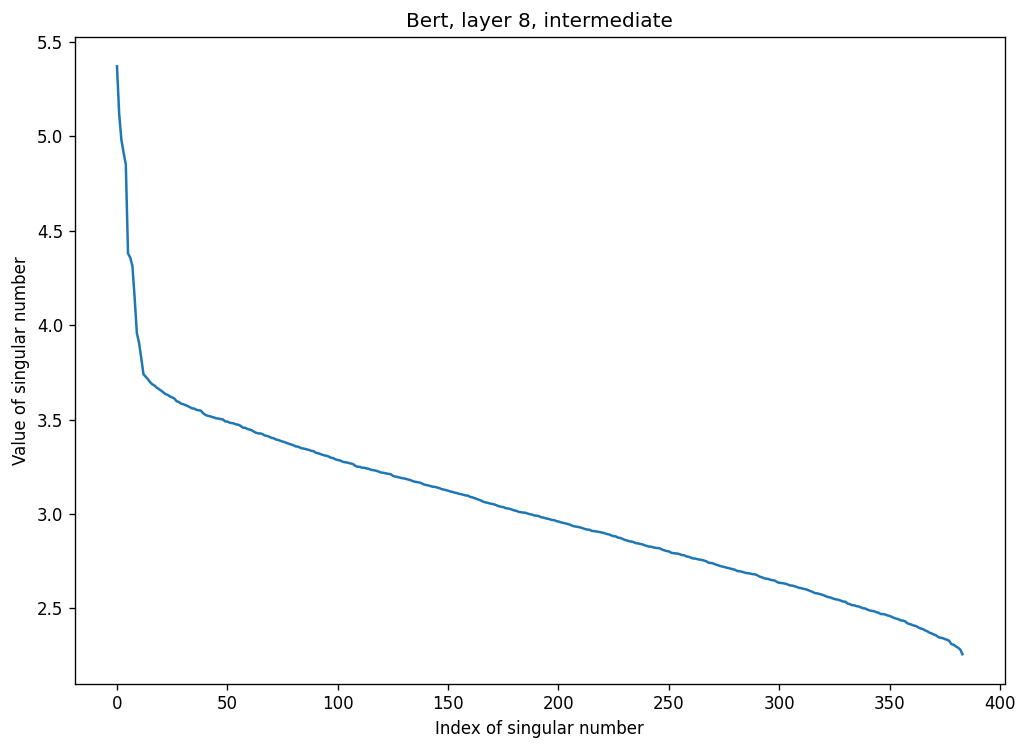

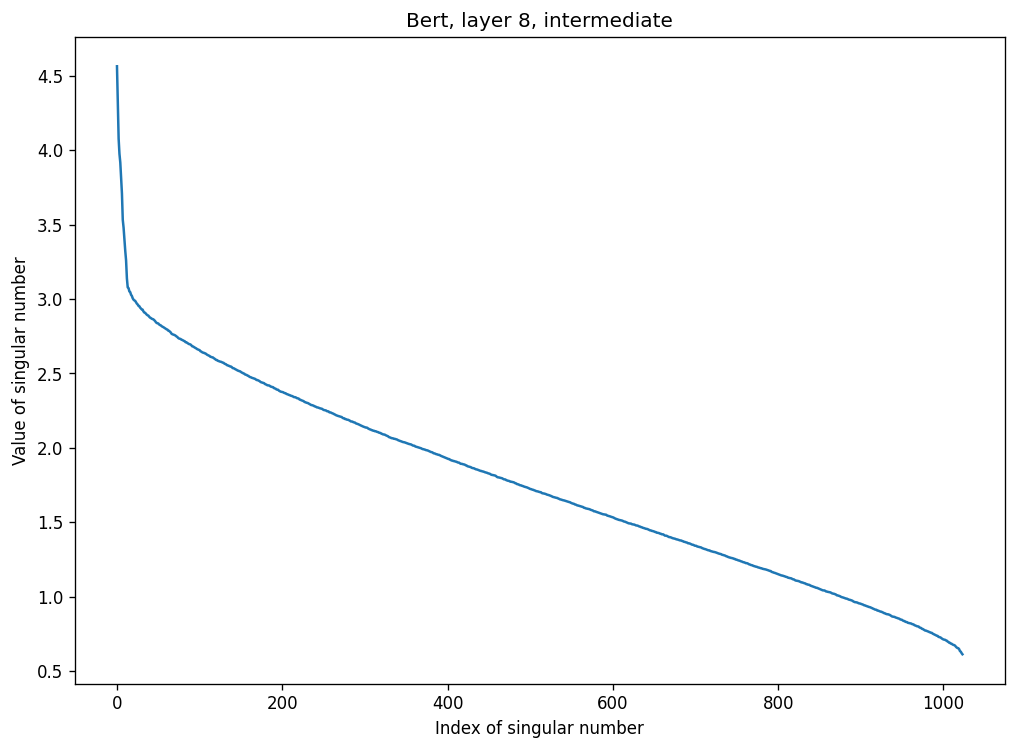

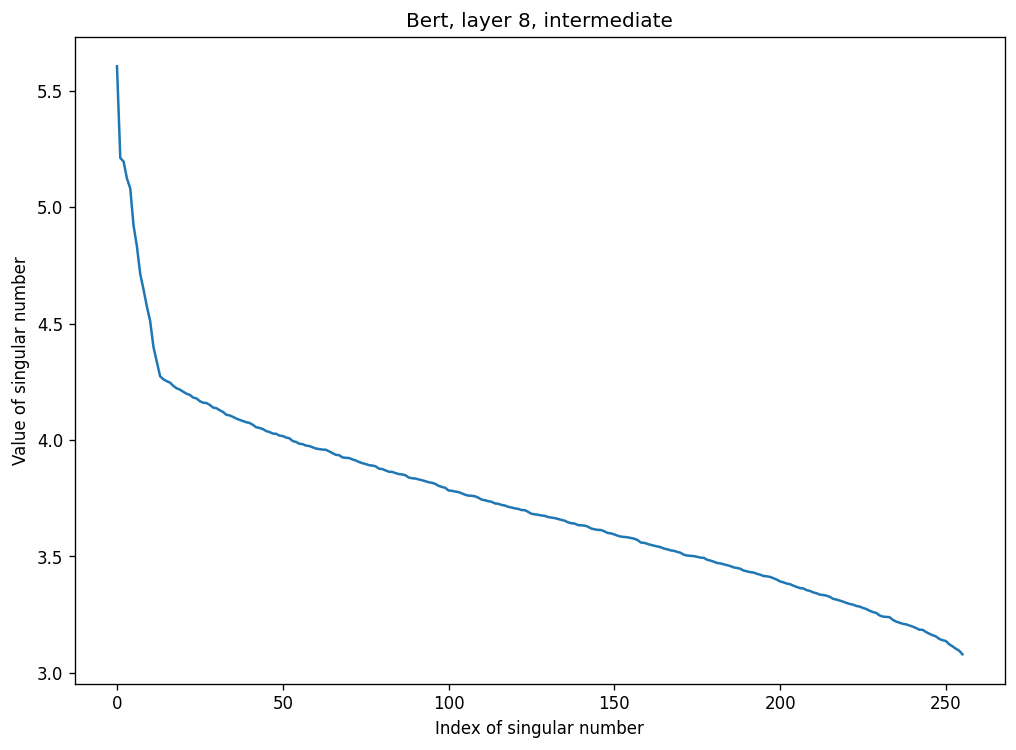

 75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:15<00:05,  1.70s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


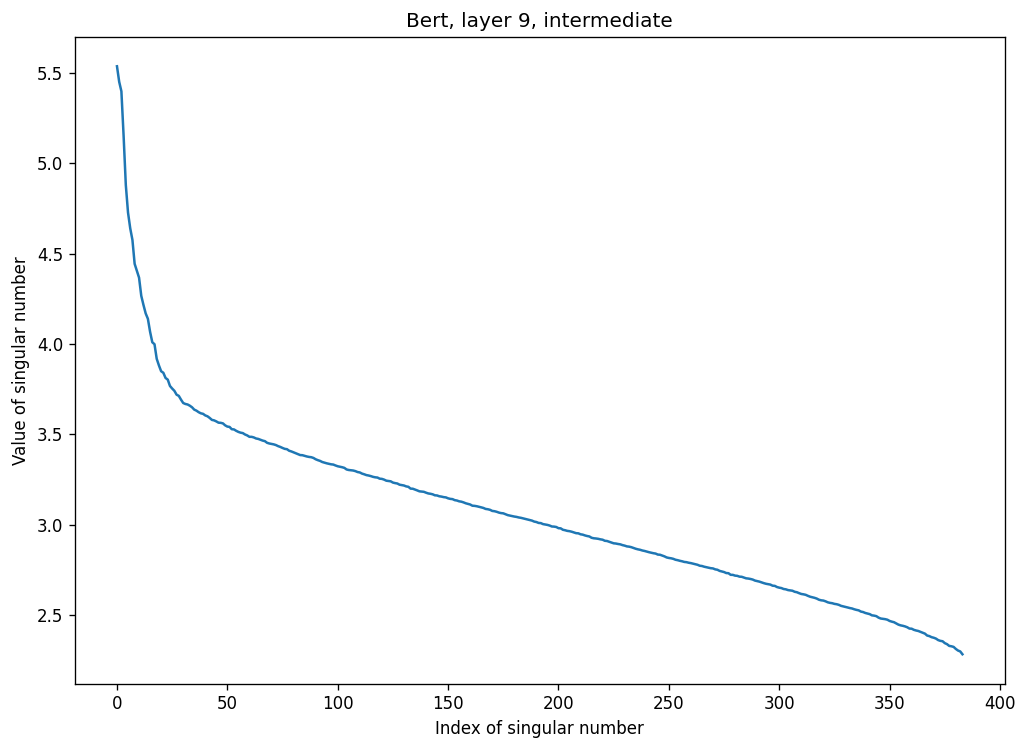

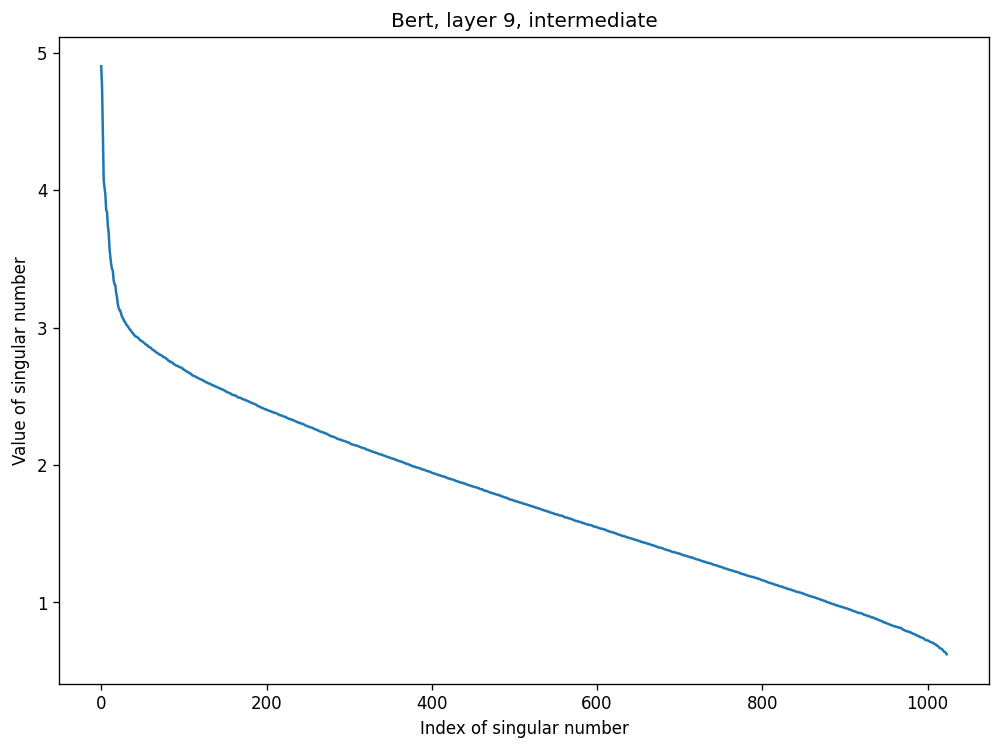

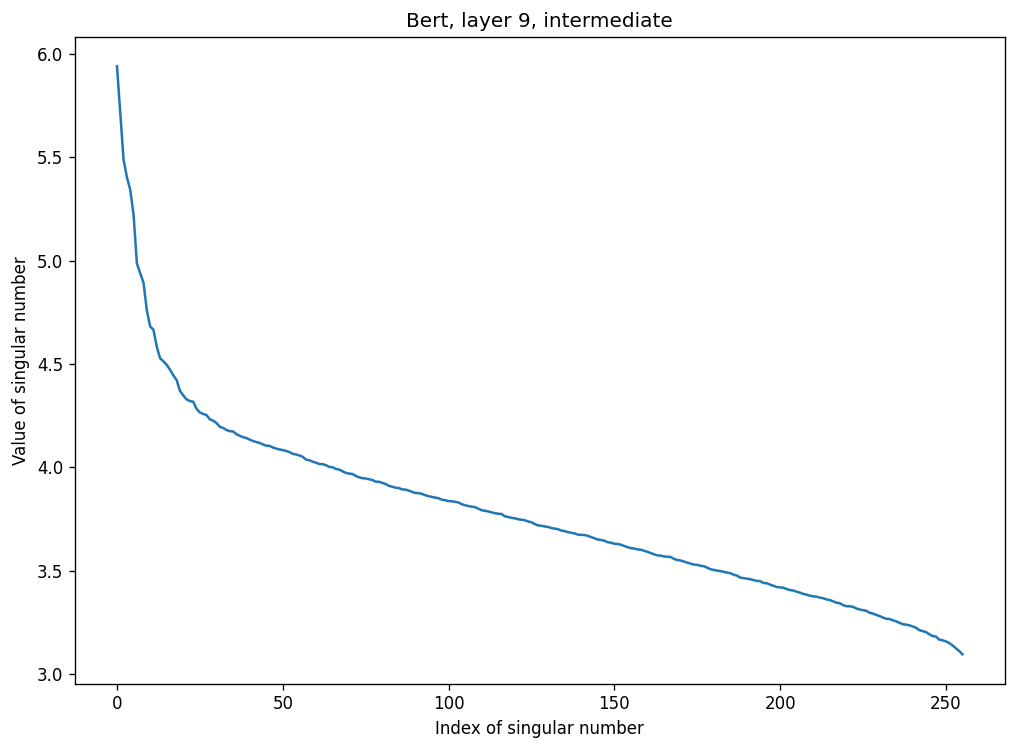

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 10/12 [00:17<00:03,  1.70s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


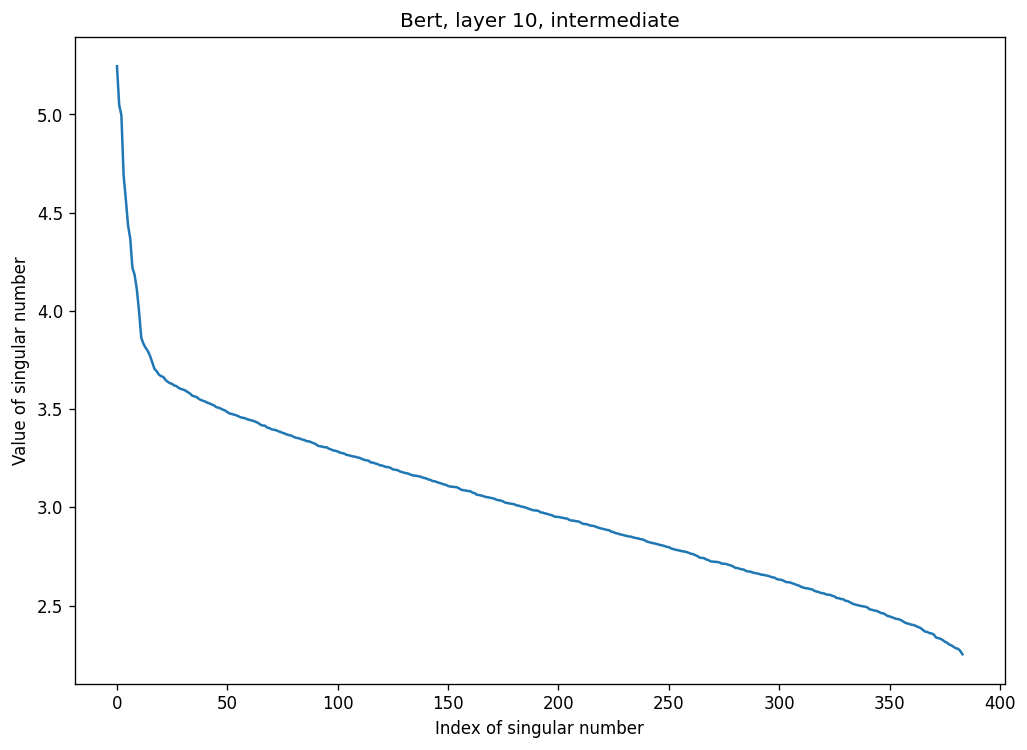

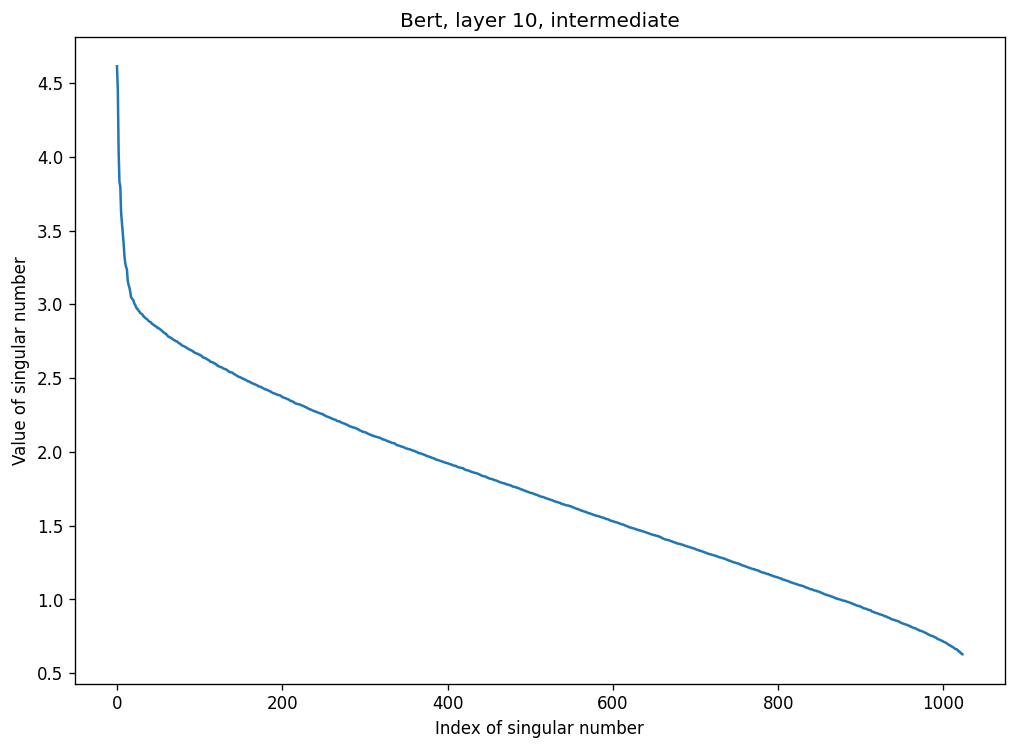

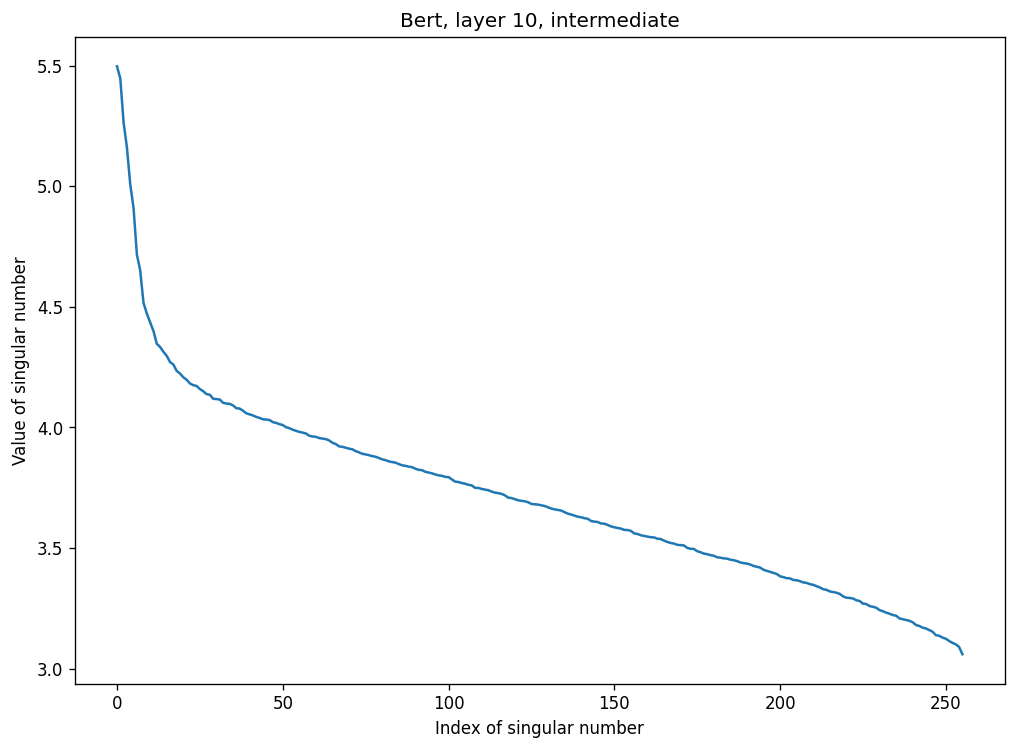

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:18<00:01,  1.69s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


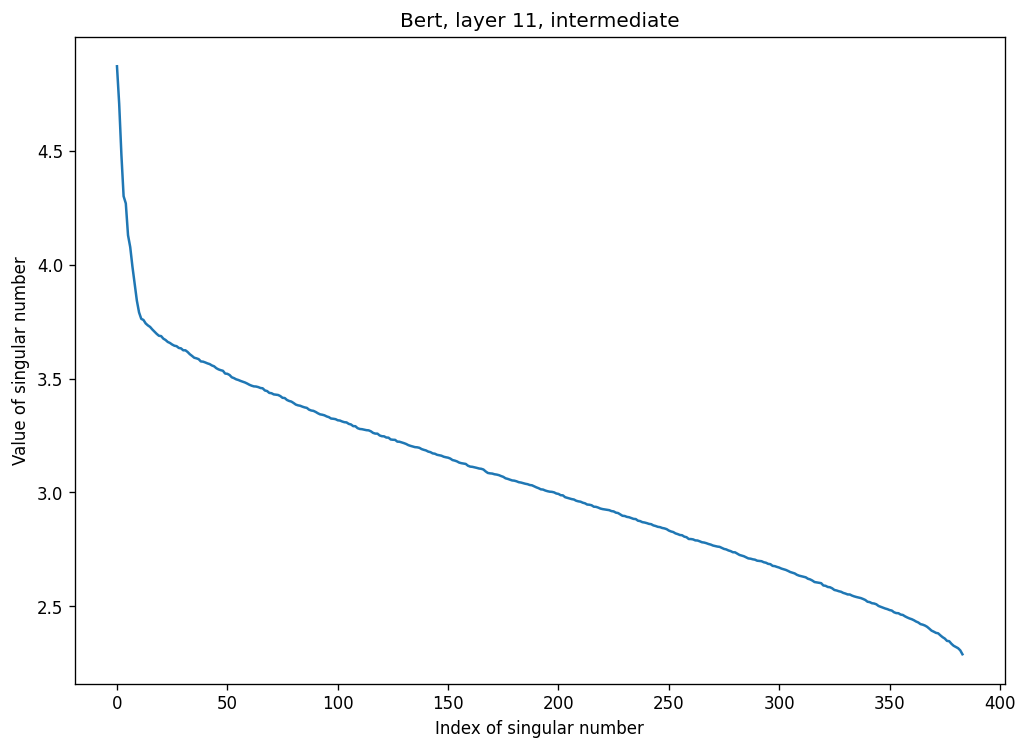

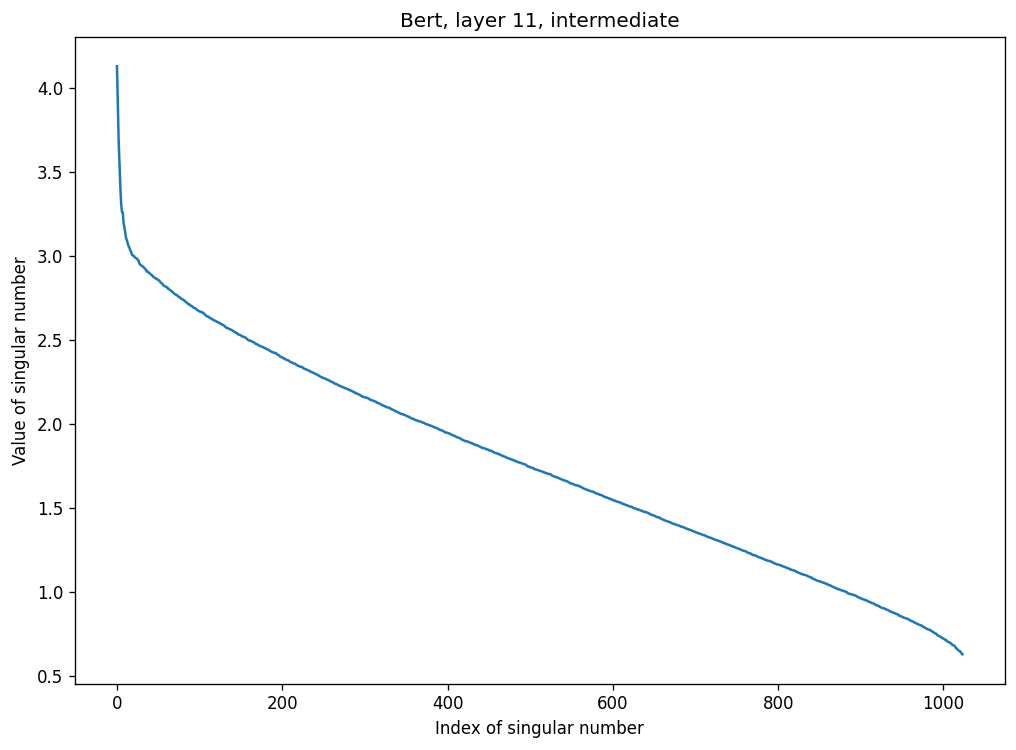

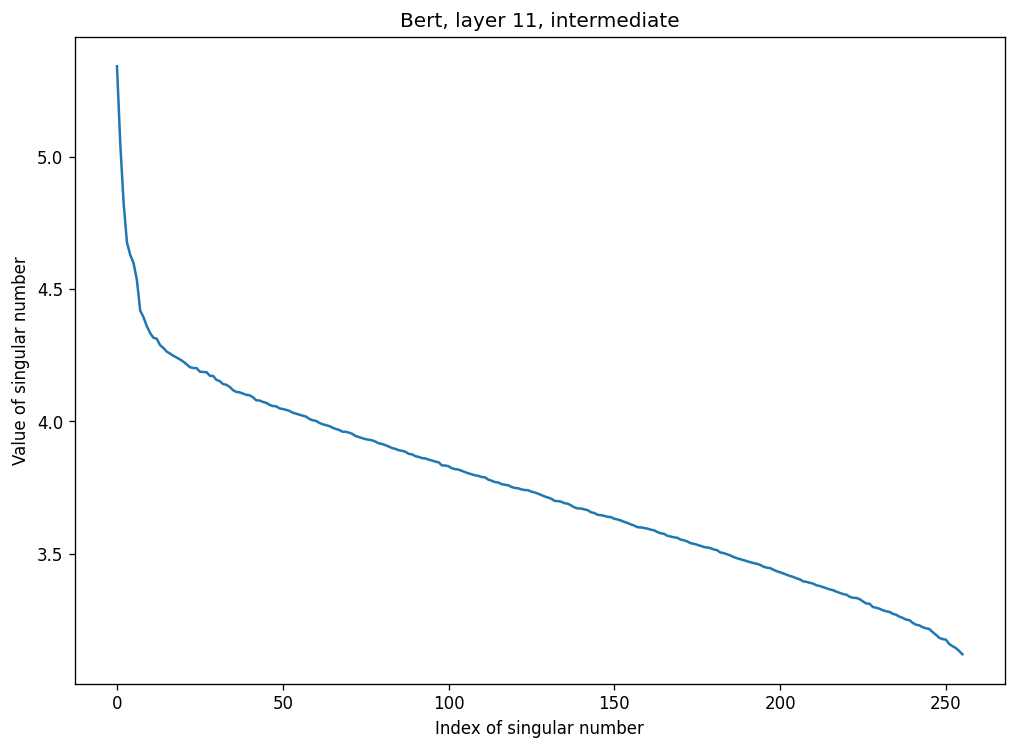

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:20<00:00,  1.72s/it]


In [42]:
ds = make_dataset_bert(bert, "intermediate", layer_to_compress=(3,4,5))
ds.to_csv("bert_intermediate_dataset.csv", index=False)

core shape1 (1, 384, 72)
core shape1 (72, 6, 72)
core shape1 (72, 4, 72)
core shape1 (72, 256, 1)


  0%|                                                                                                                        | 0/12 [00:00<?, ?it/s]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


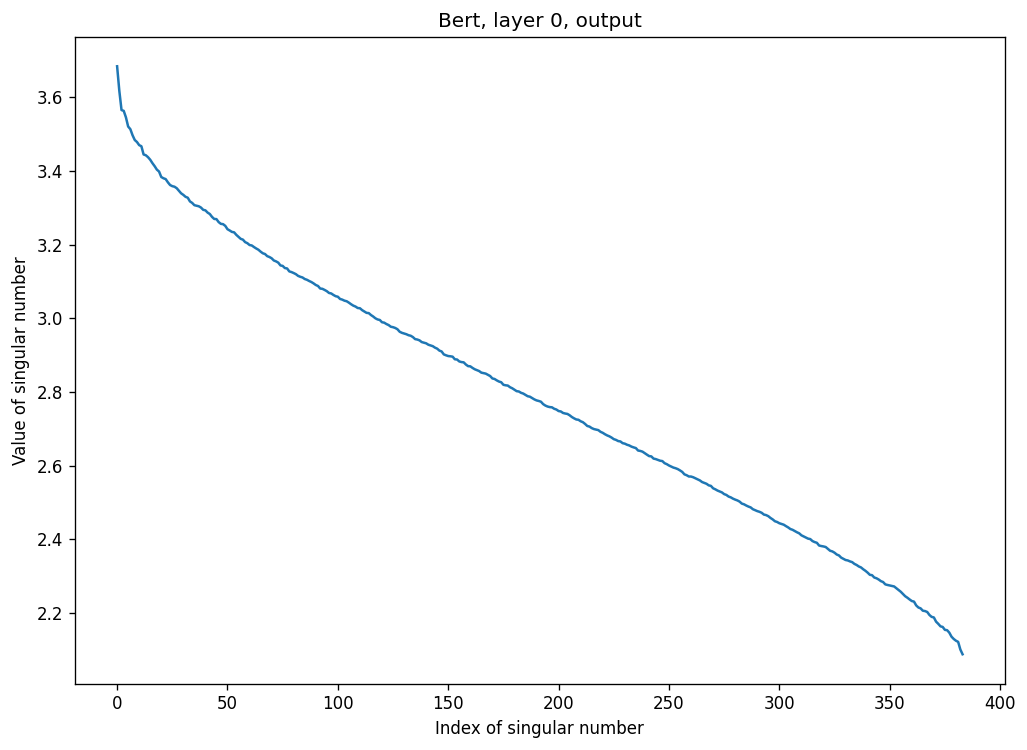

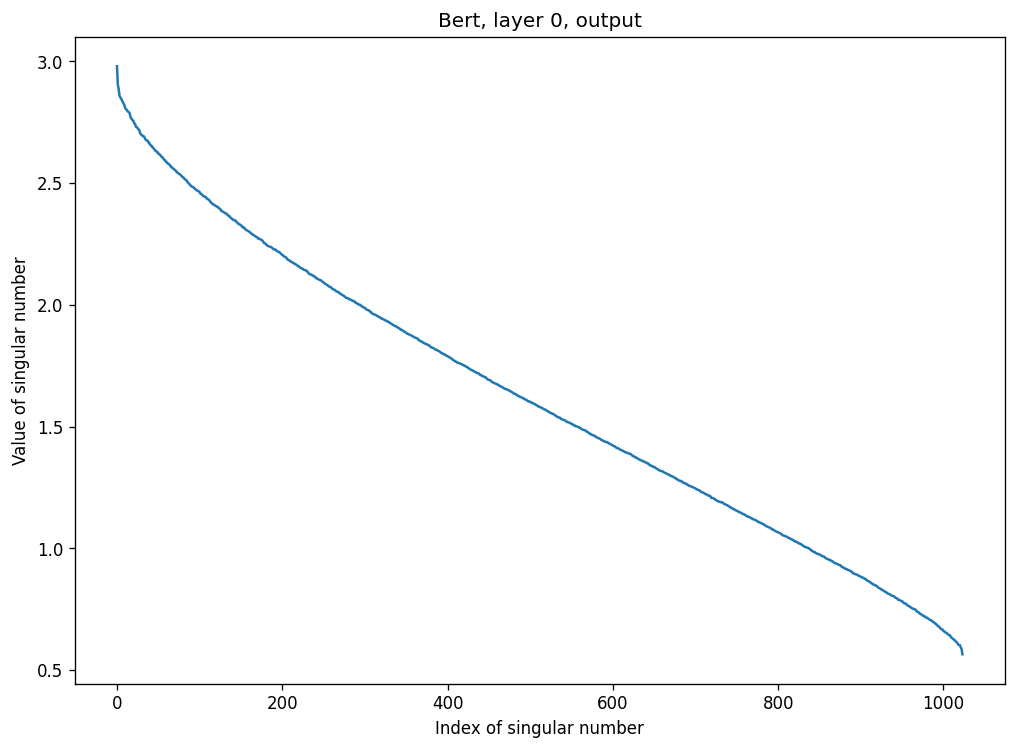

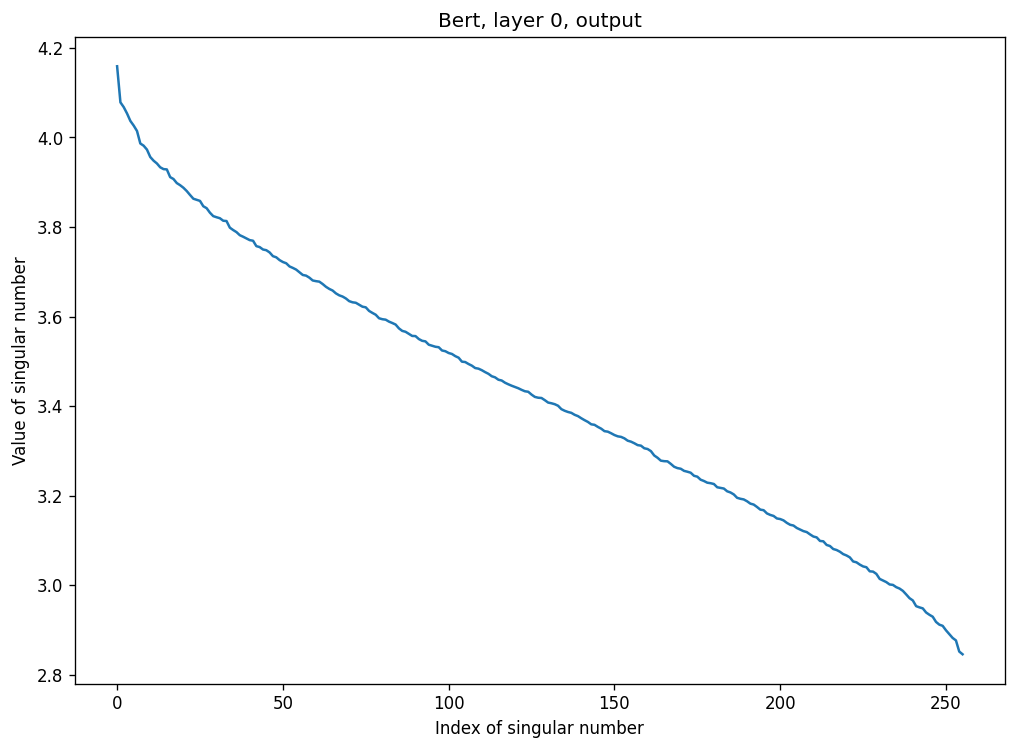

  8%|█████████▎                                                                                                      | 1/12 [00:01<00:18,  1.71s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


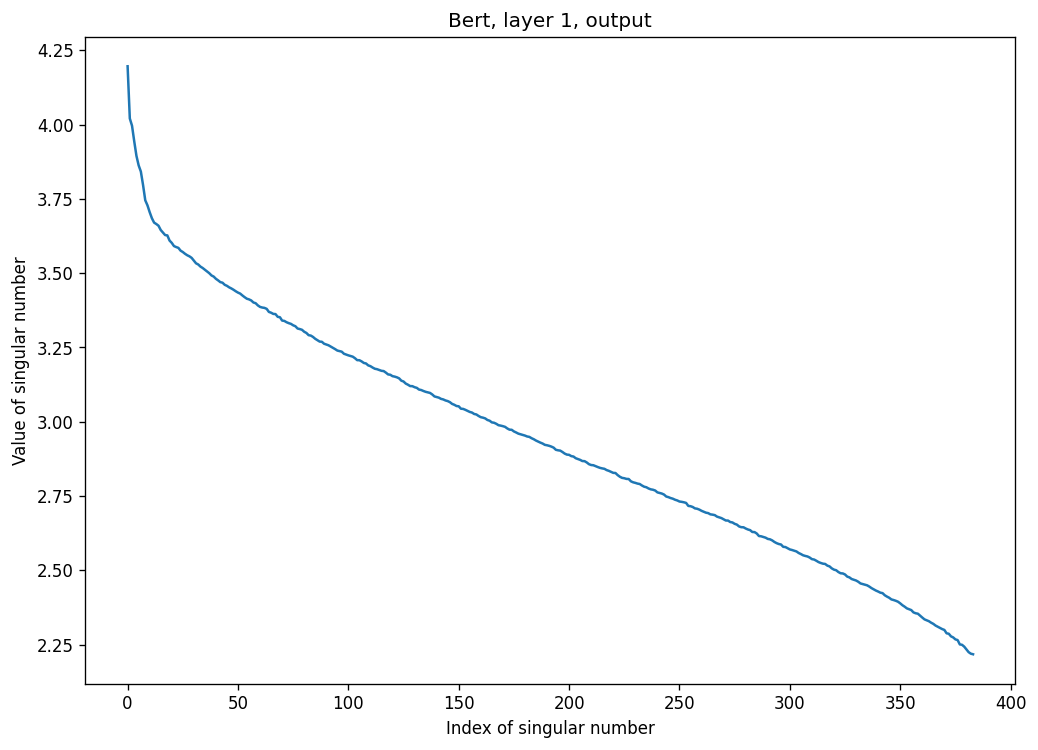

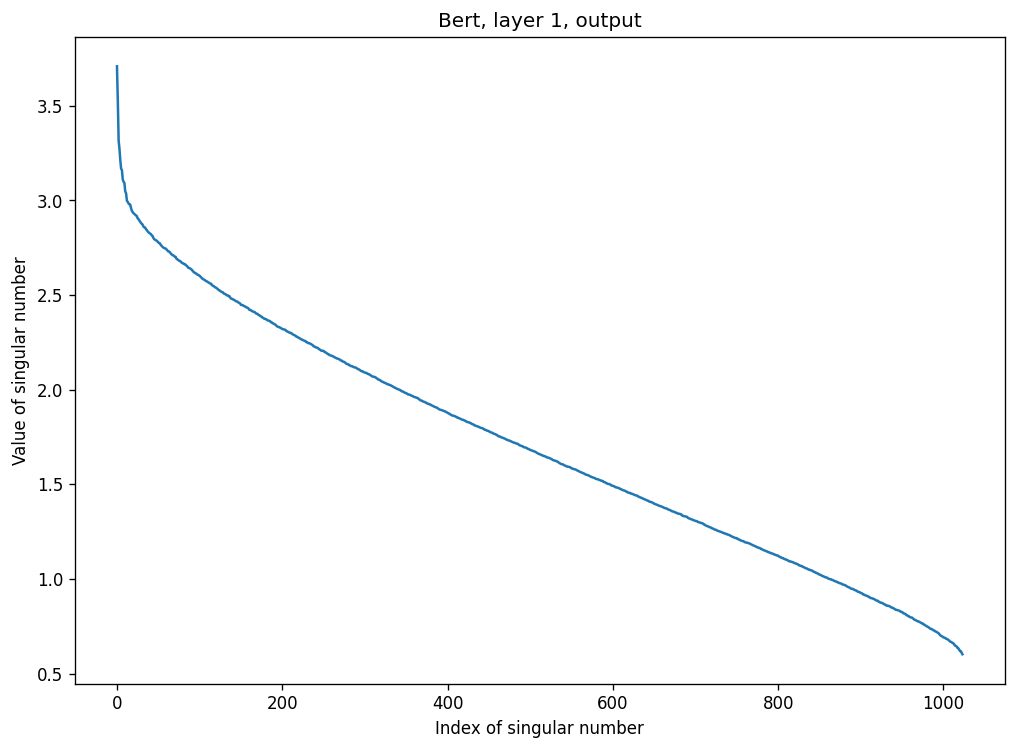

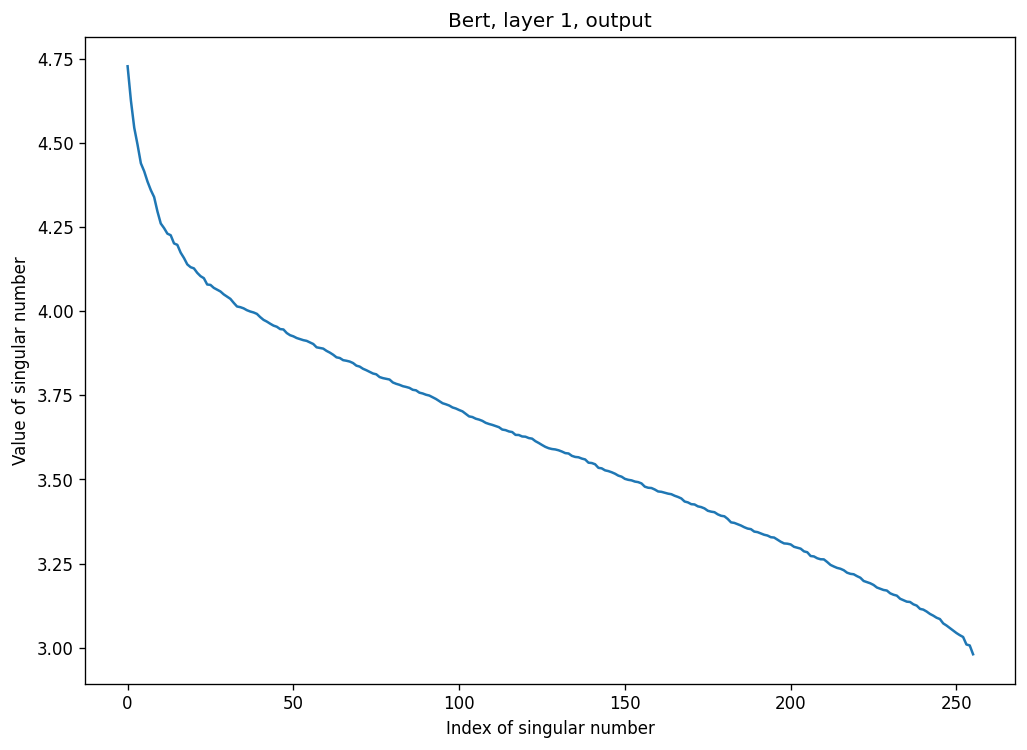

 17%|██████████████████▋                                                                                             | 2/12 [00:03<00:16,  1.70s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


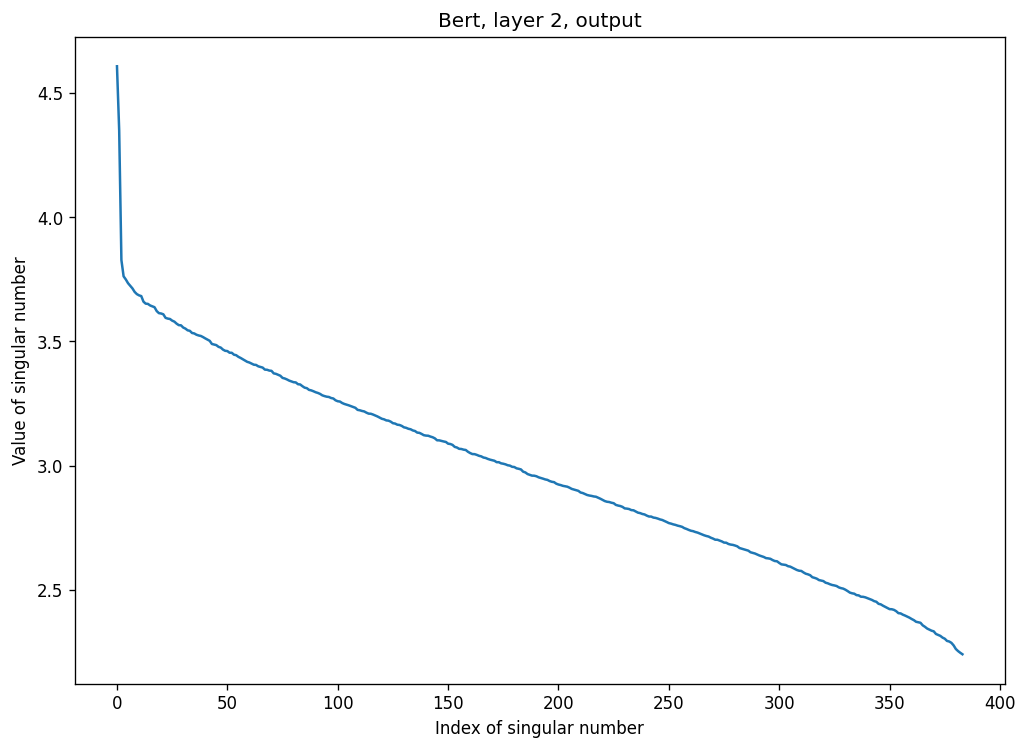

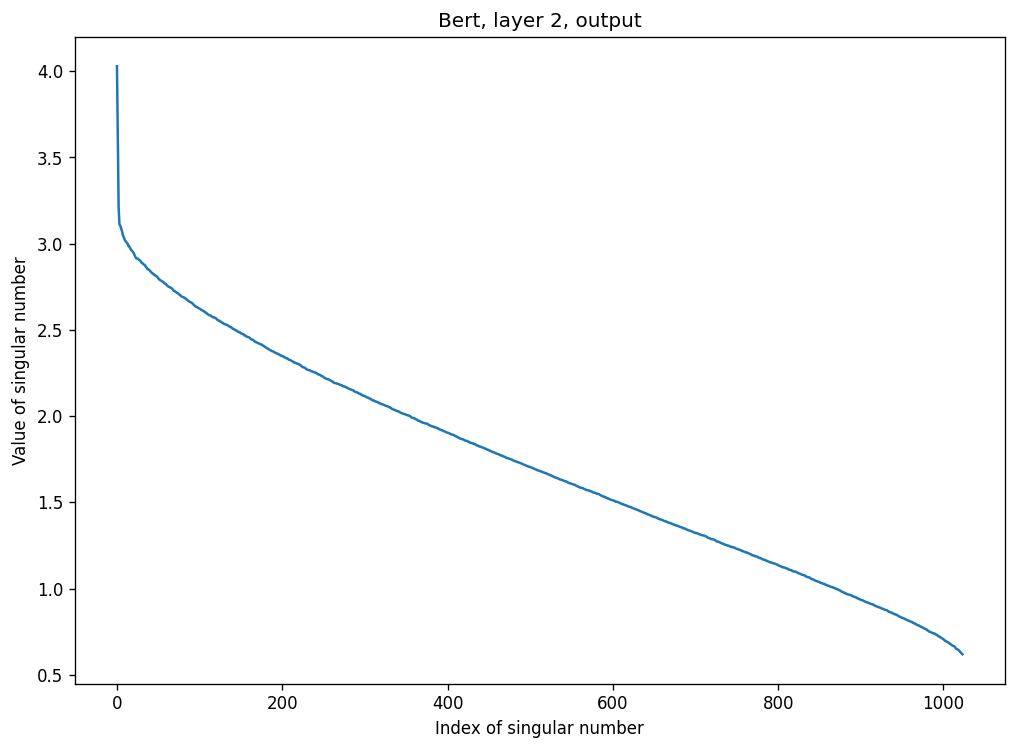

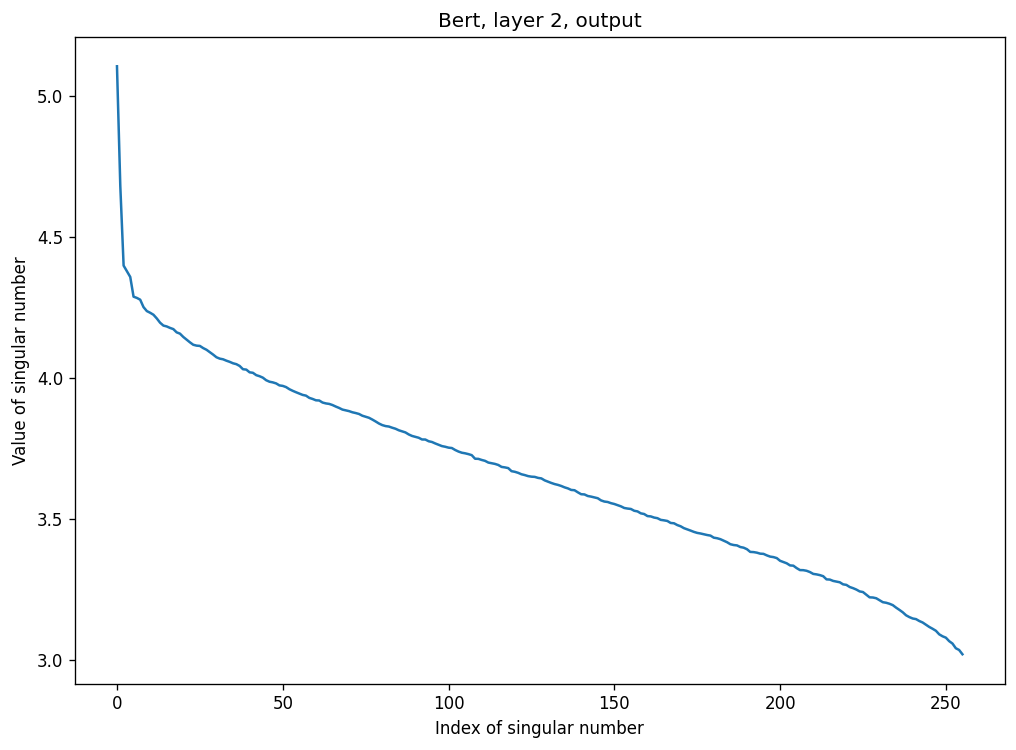

 25%|████████████████████████████                                                                                    | 3/12 [00:05<00:15,  1.69s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


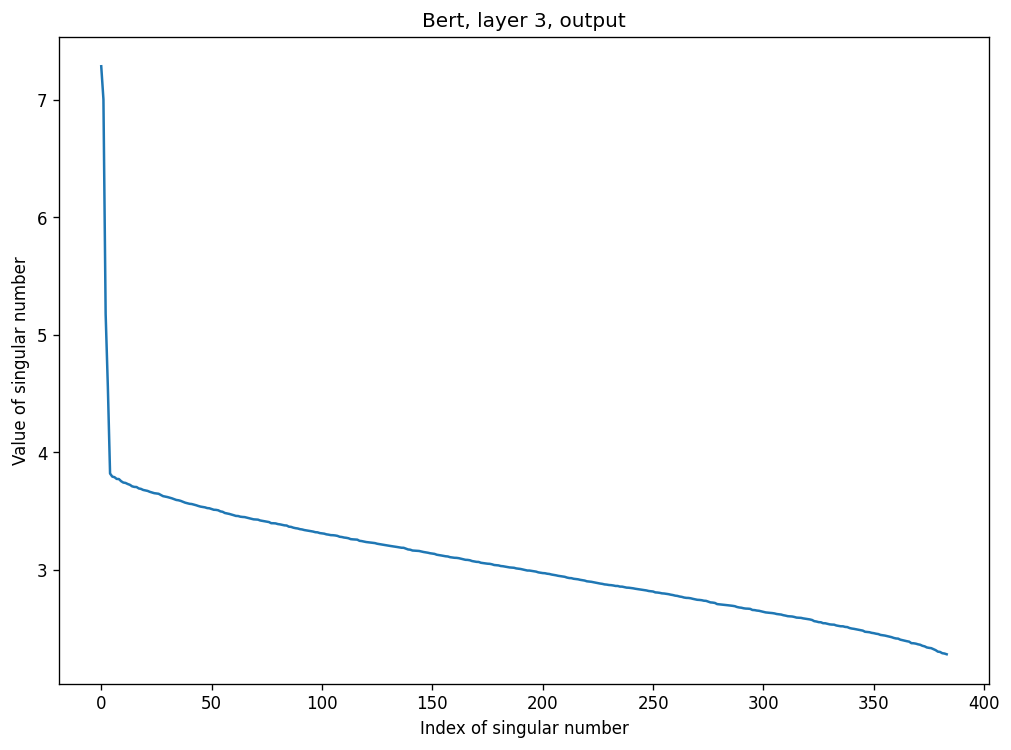

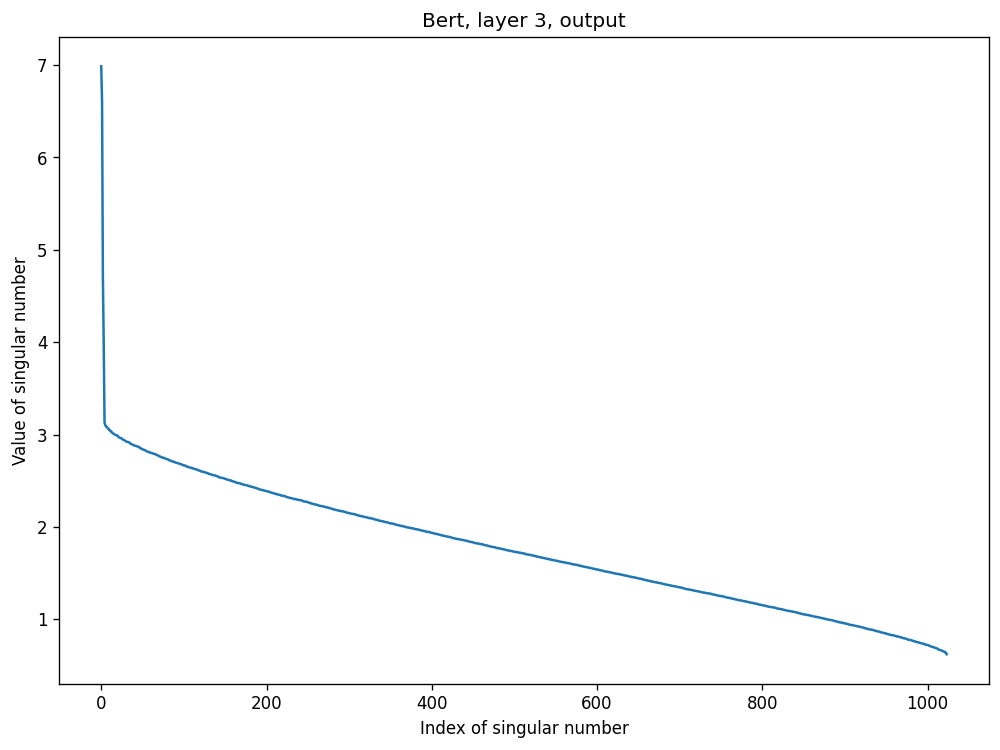

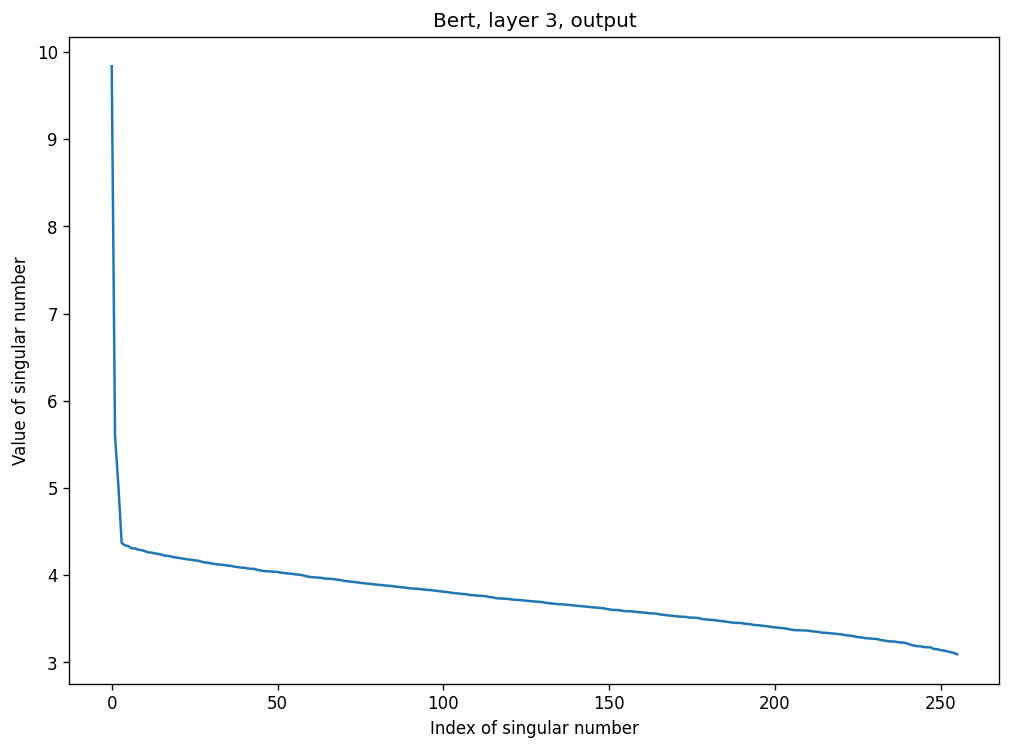

 33%|█████████████████████████████████████▎                                                                          | 4/12 [00:06<00:13,  1.71s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


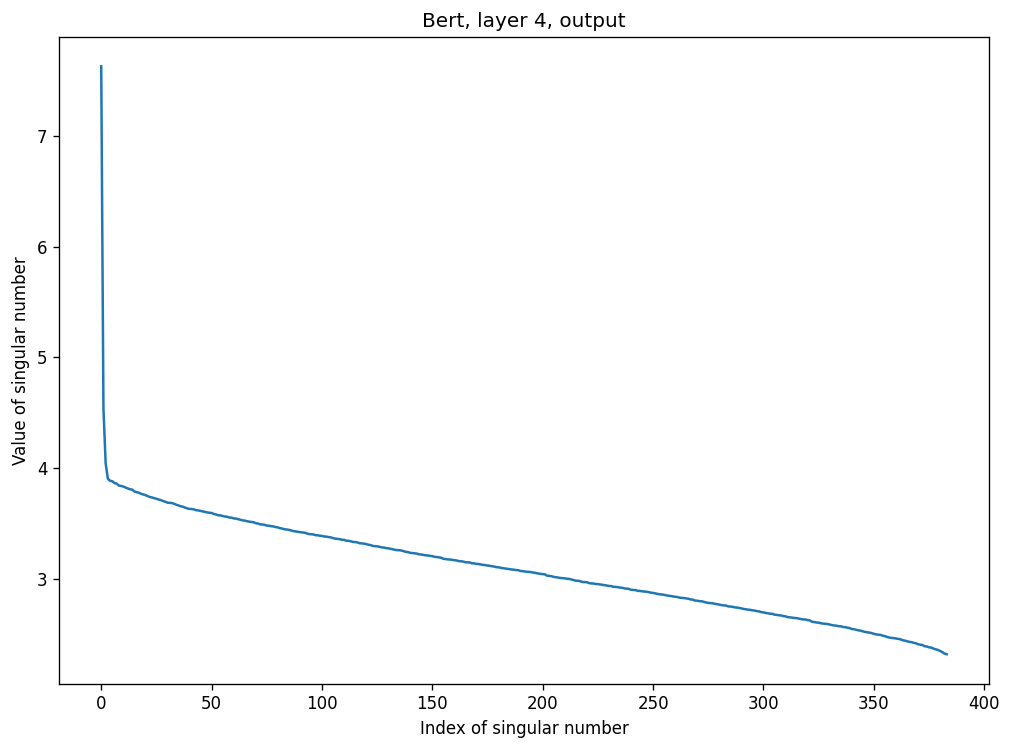

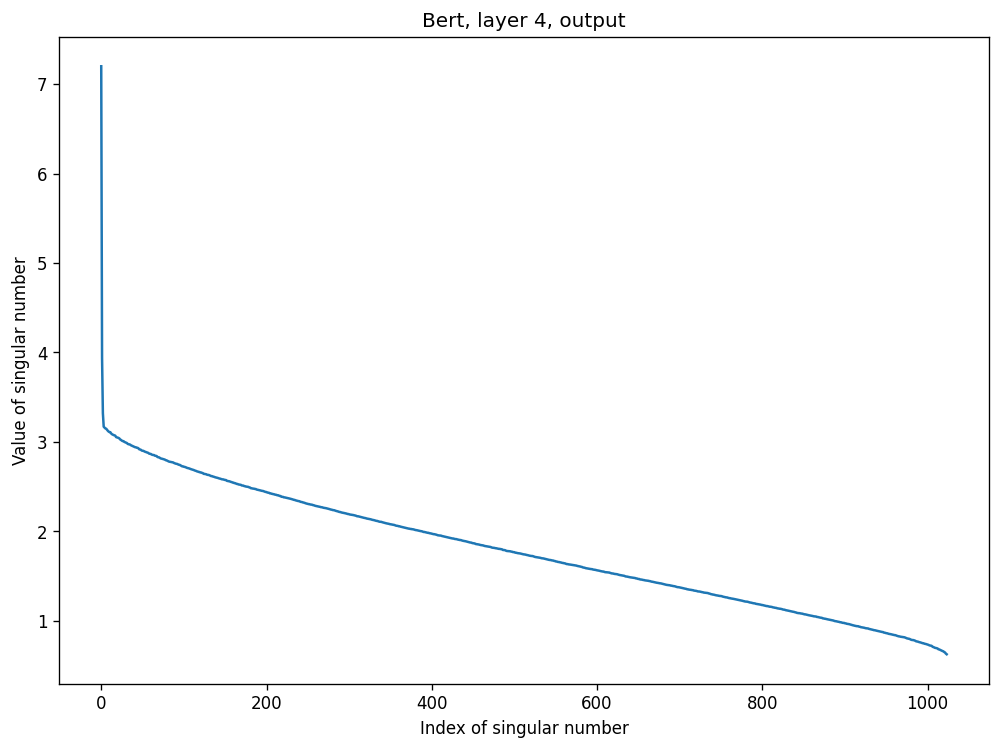

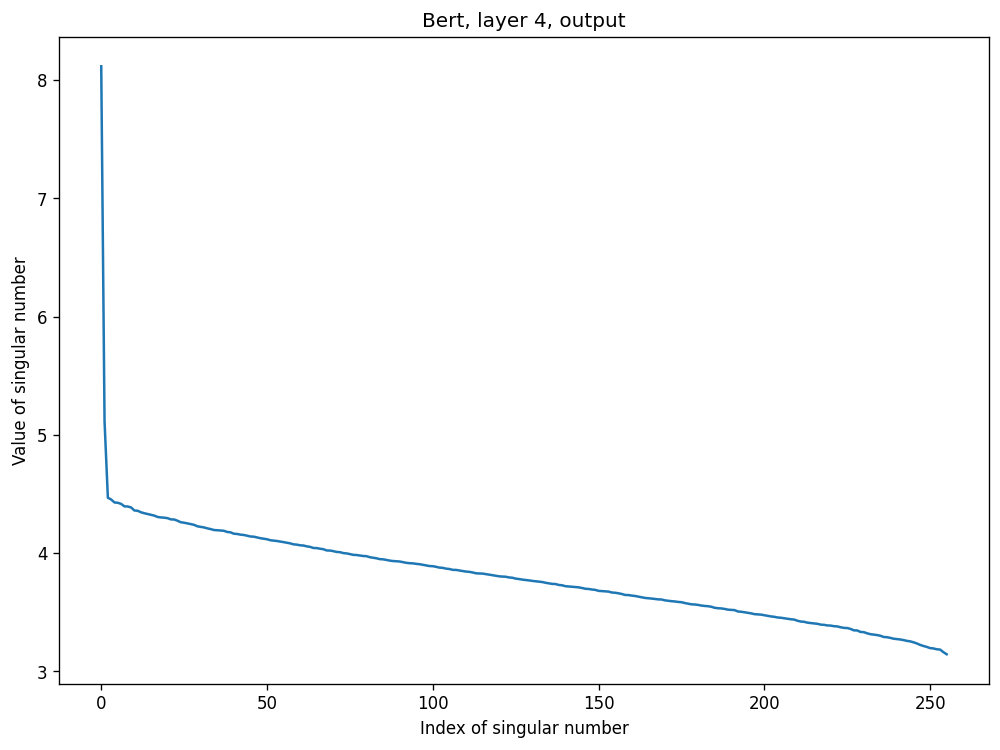

 42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:08<00:12,  1.76s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


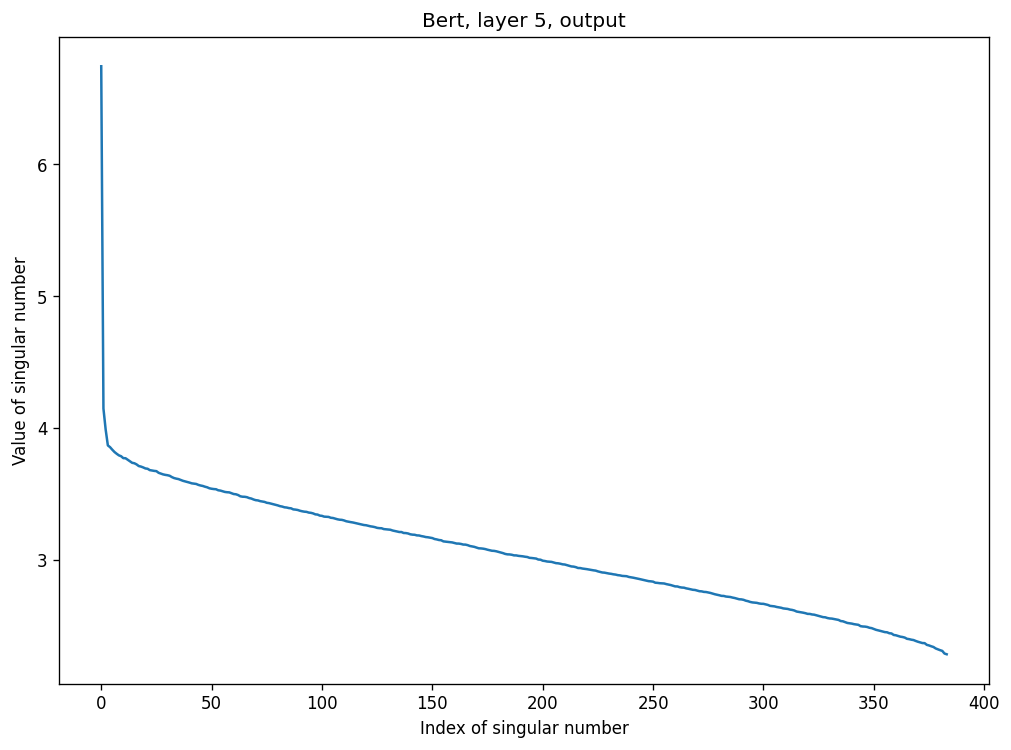

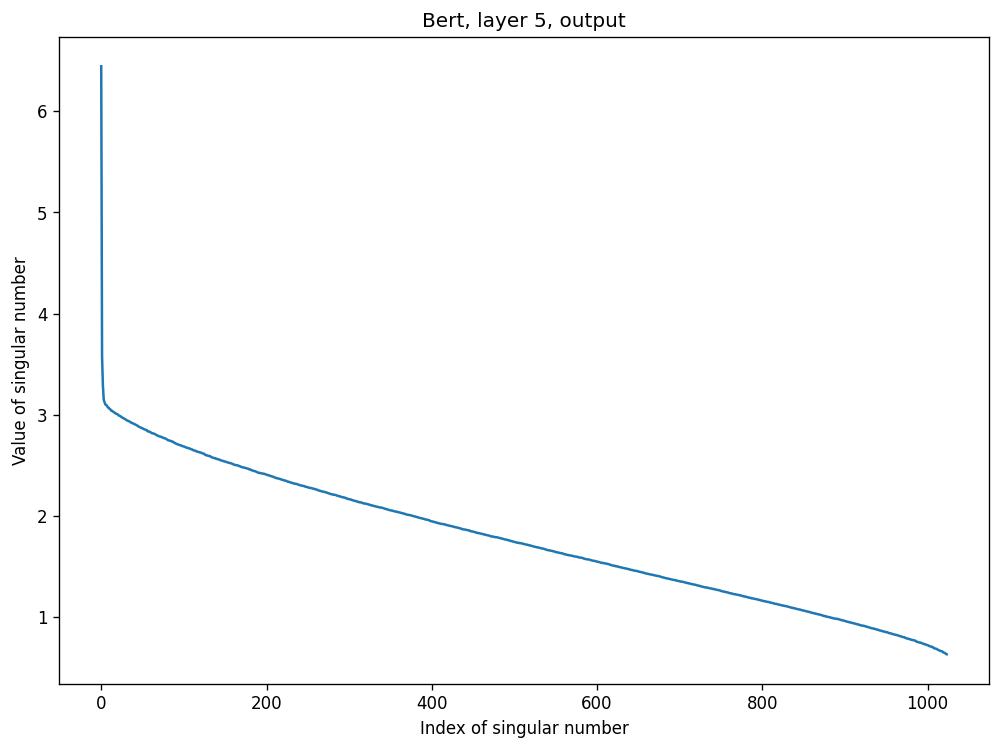

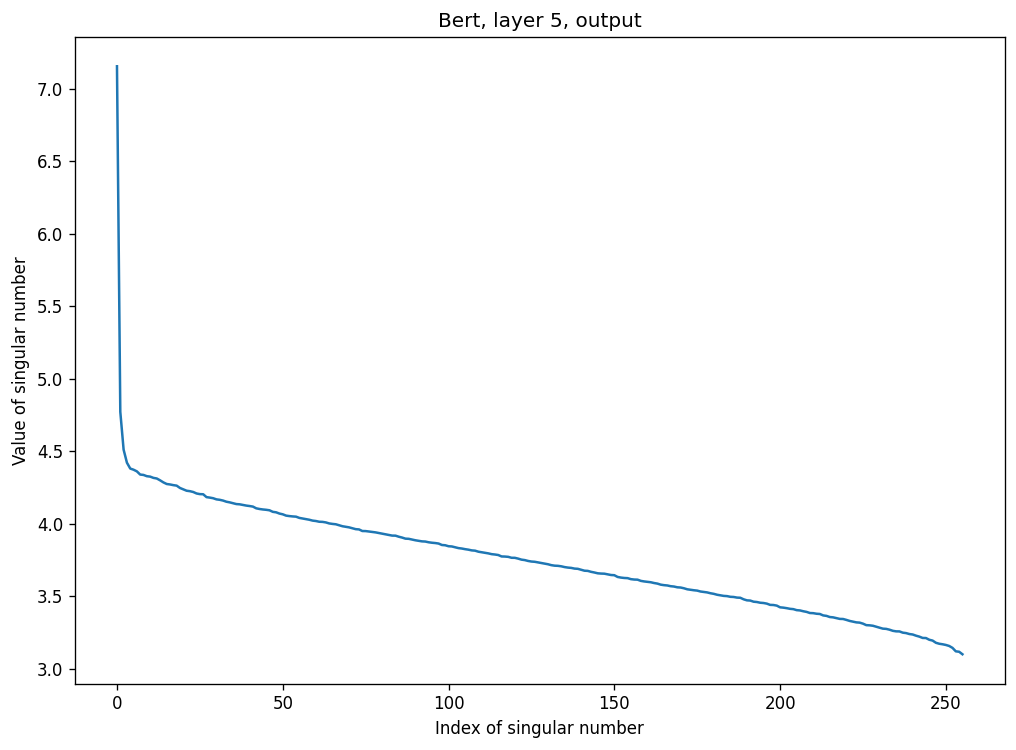

 50%|████████████████████████████████████████████████████████                                                        | 6/12 [00:10<00:10,  1.74s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


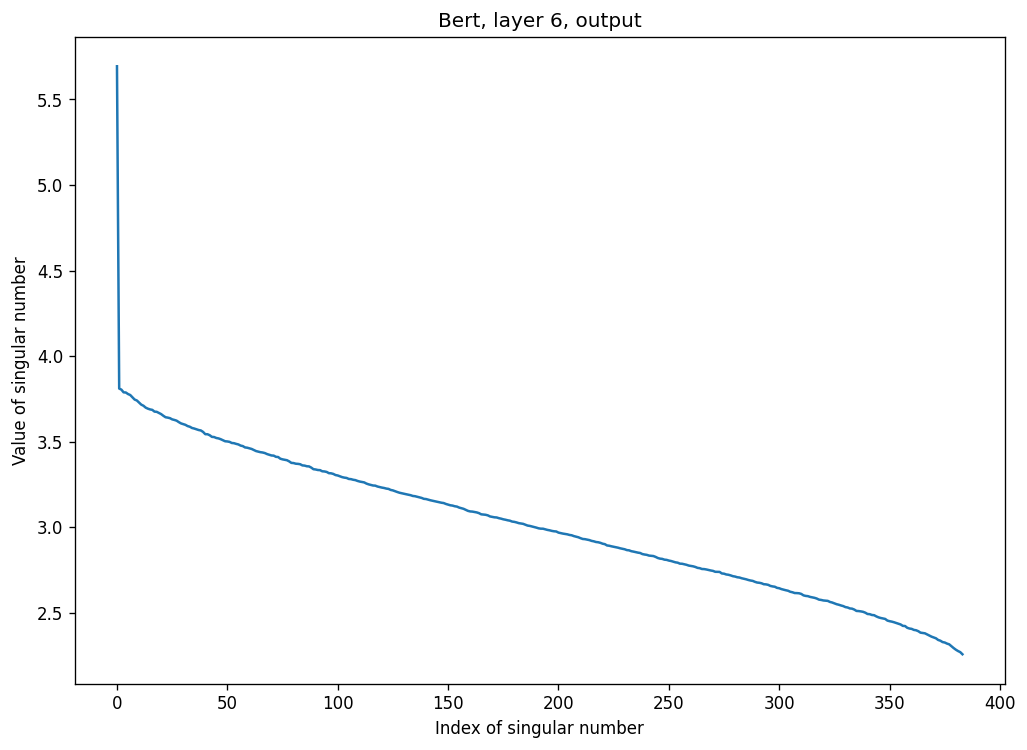

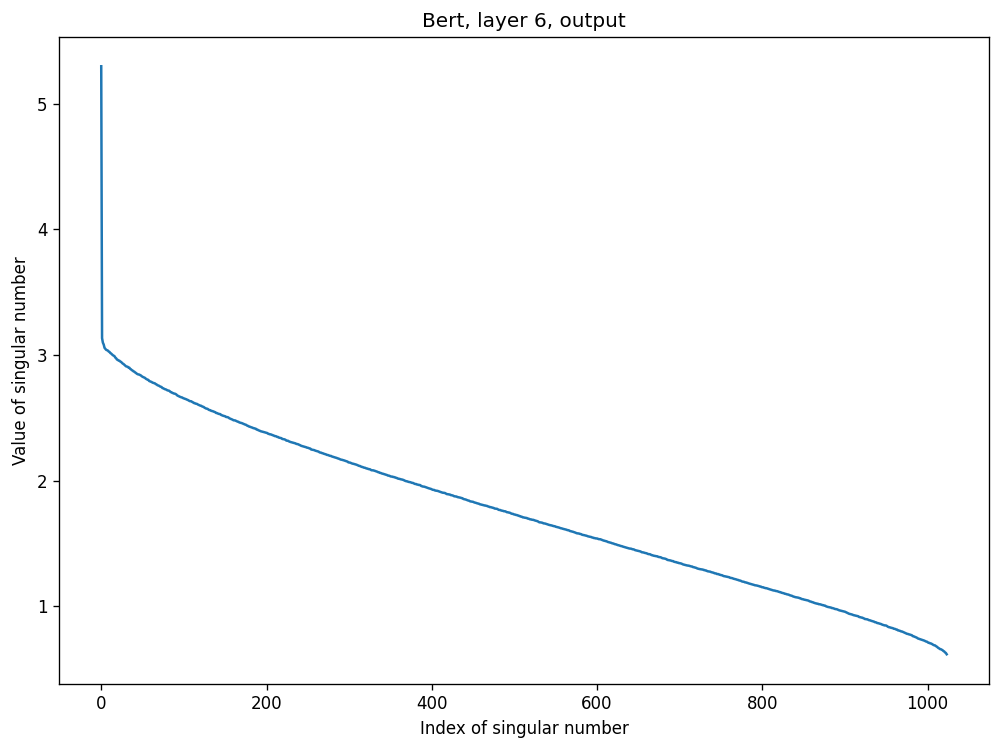

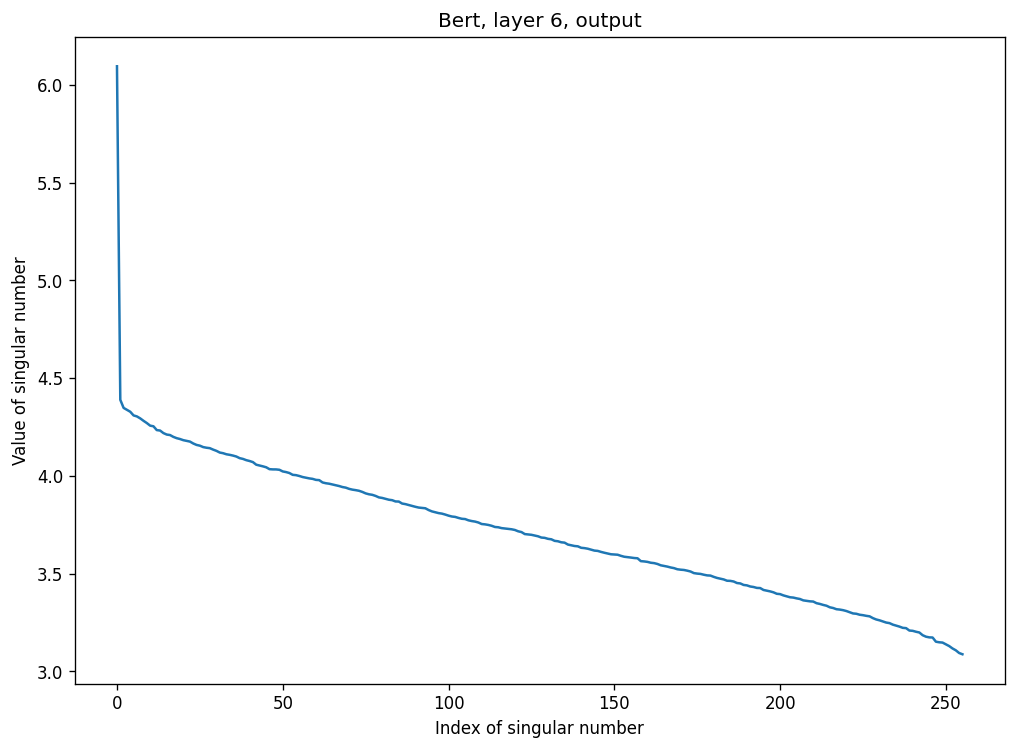

 58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:12<00:08,  1.72s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


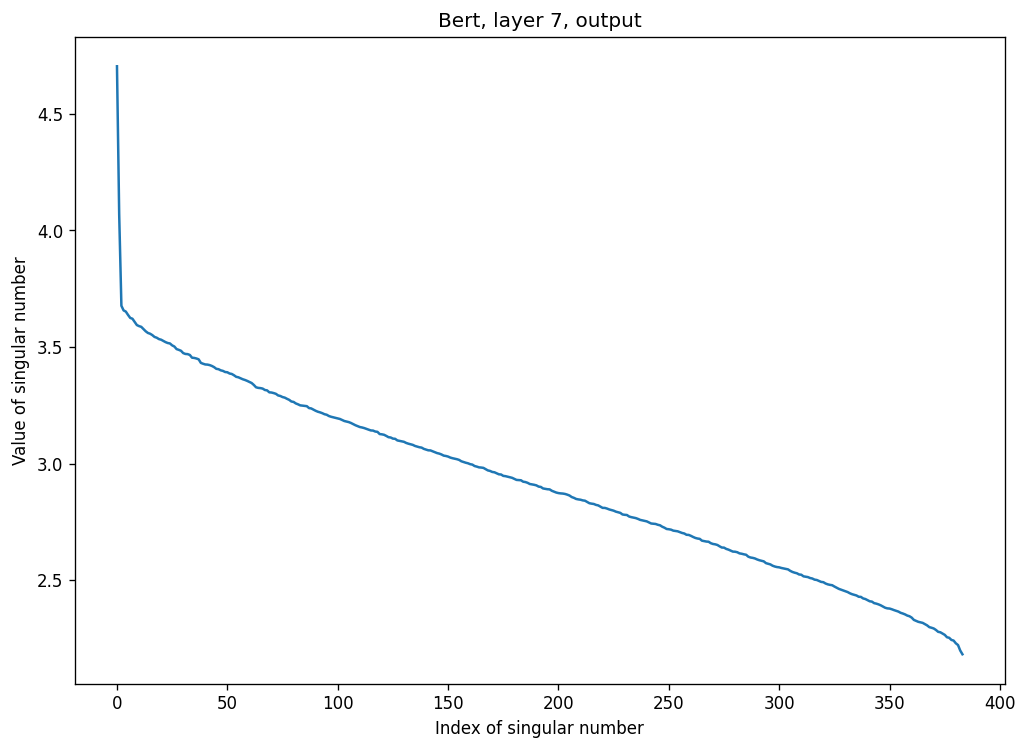

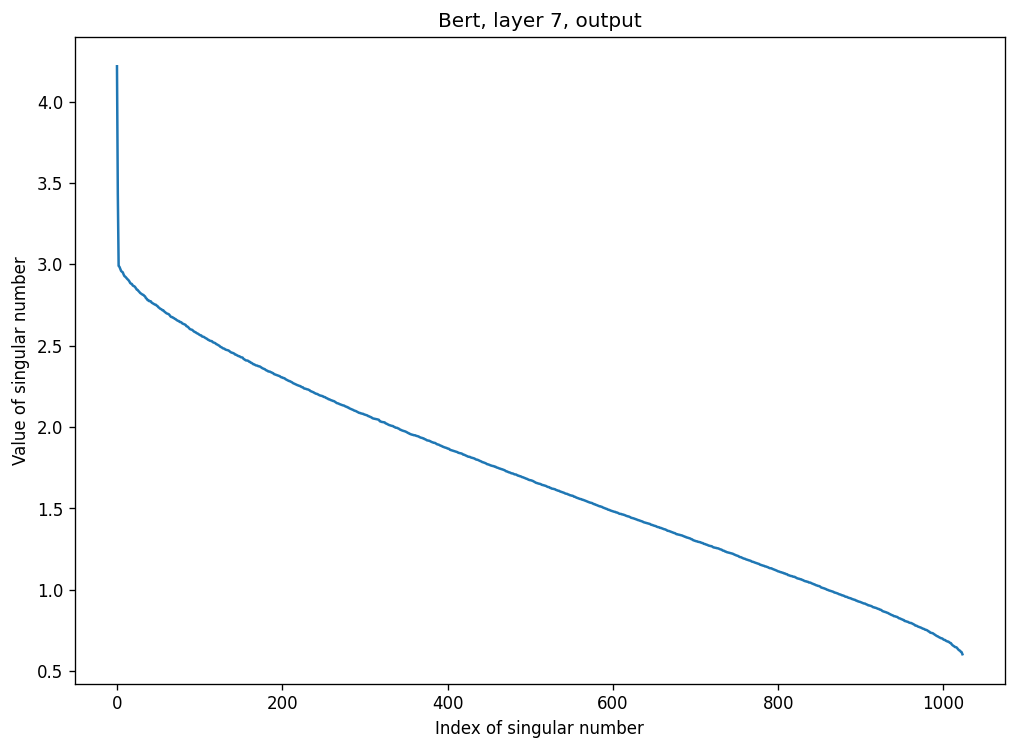

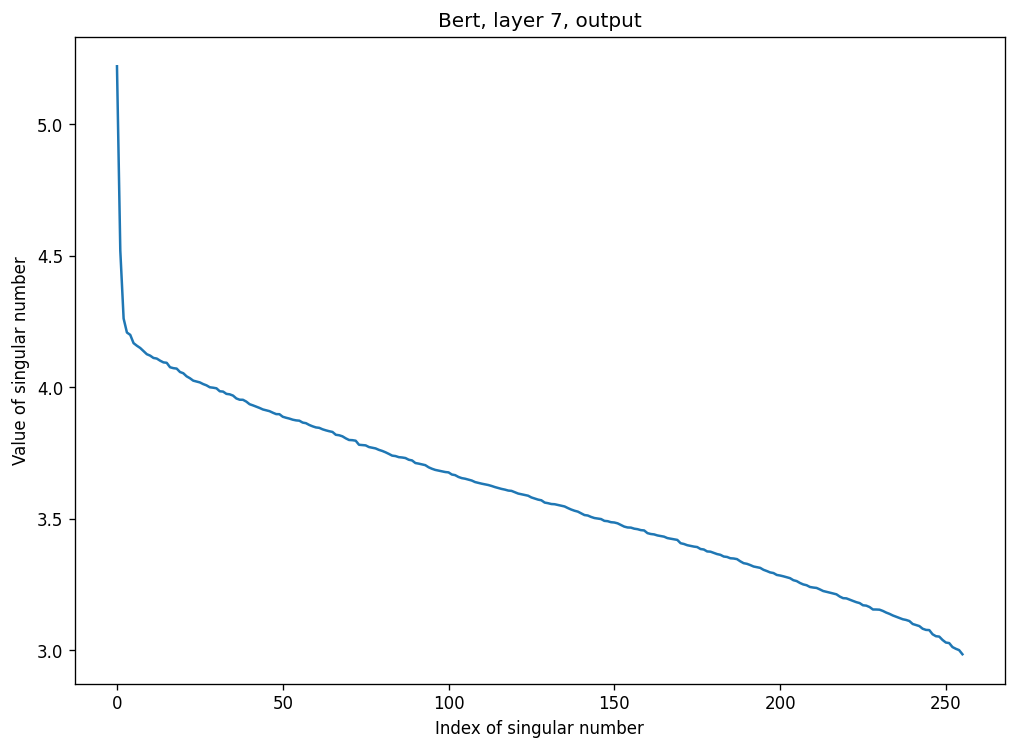

 67%|██████████████████████████████████████████████████████████████████████████▋                                     | 8/12 [00:13<00:06,  1.70s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


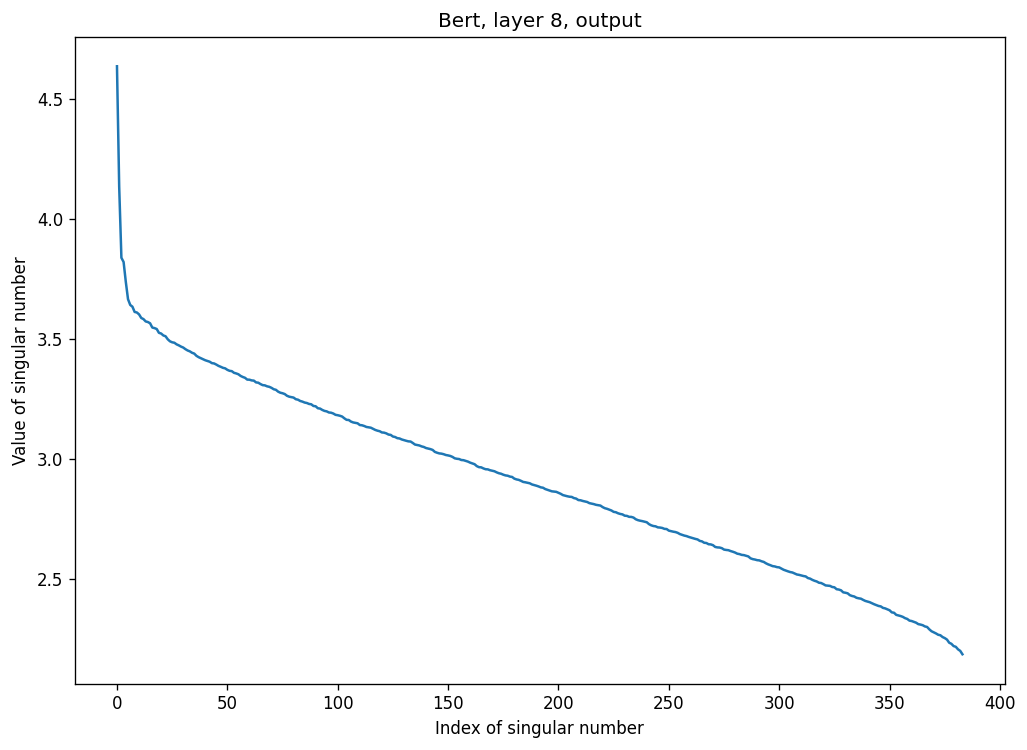

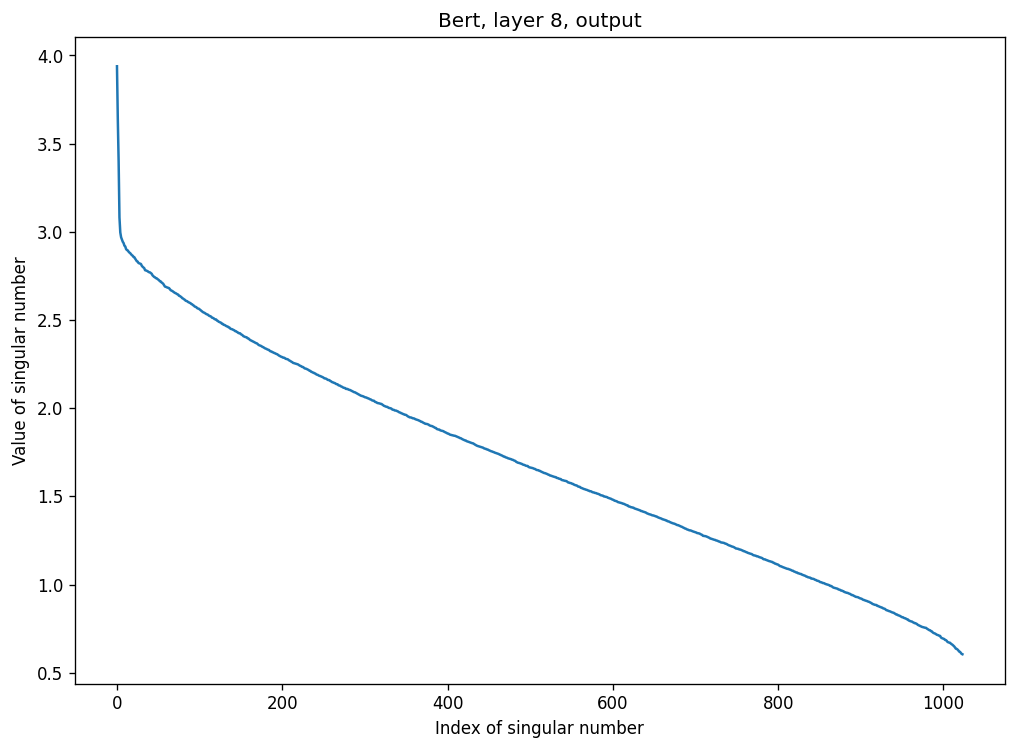

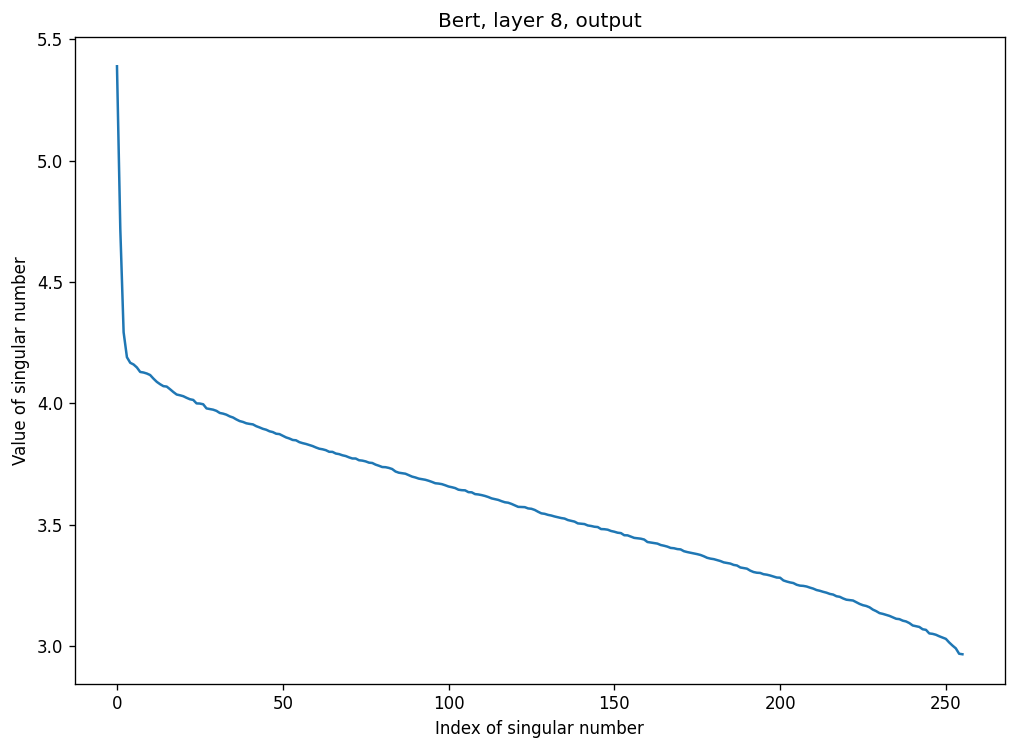

 75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:15<00:05,  1.70s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


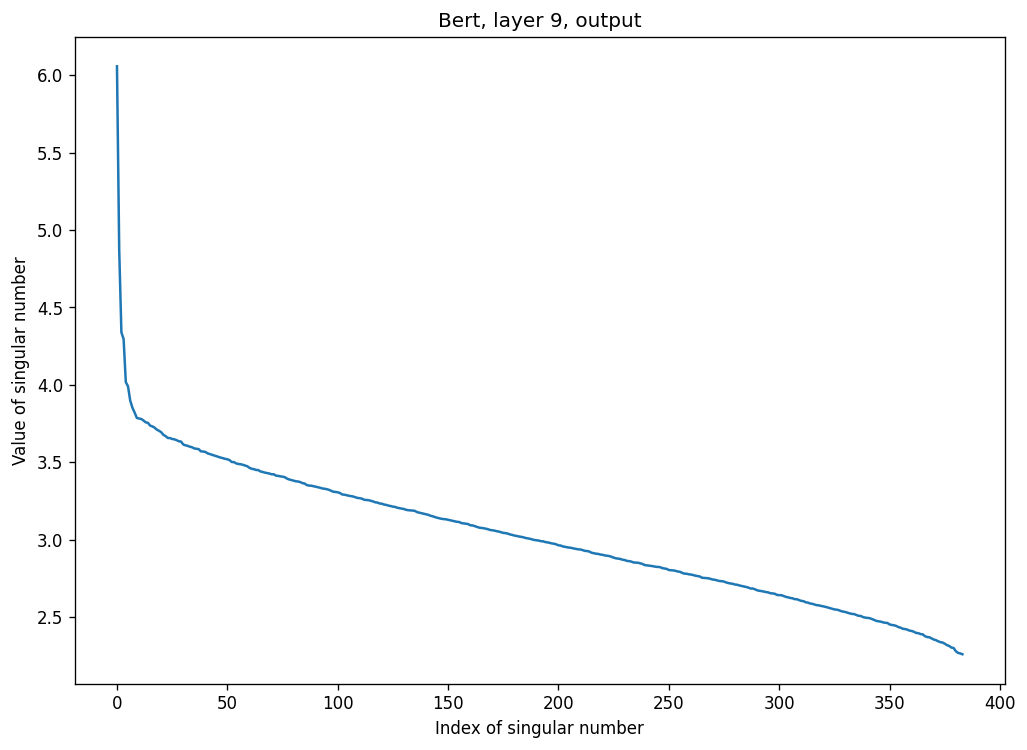

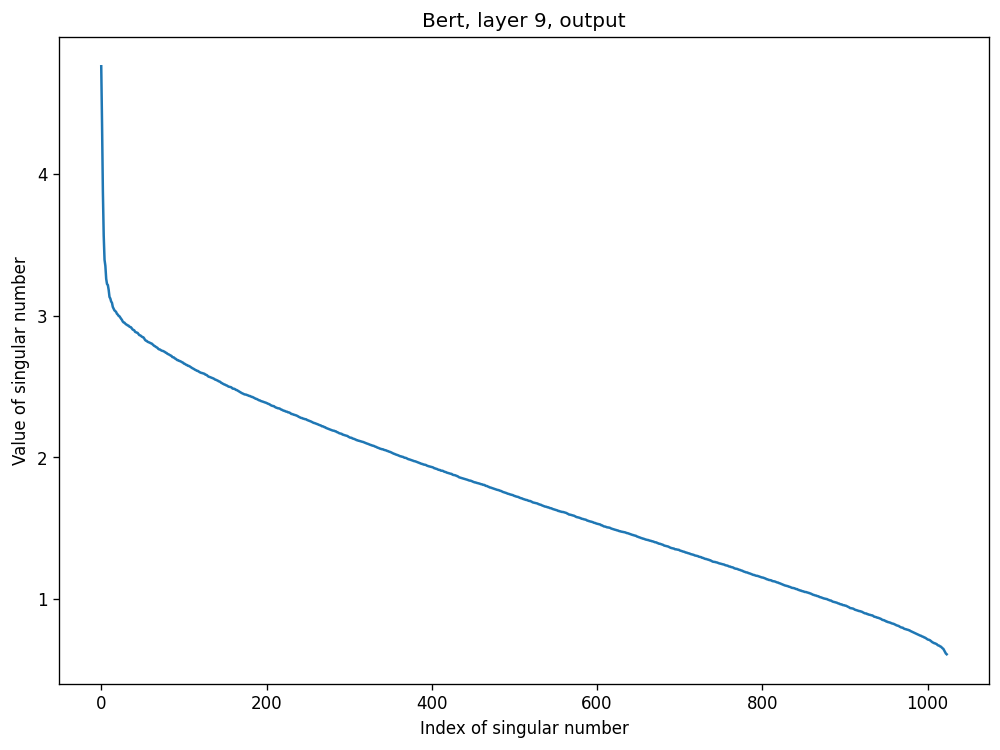

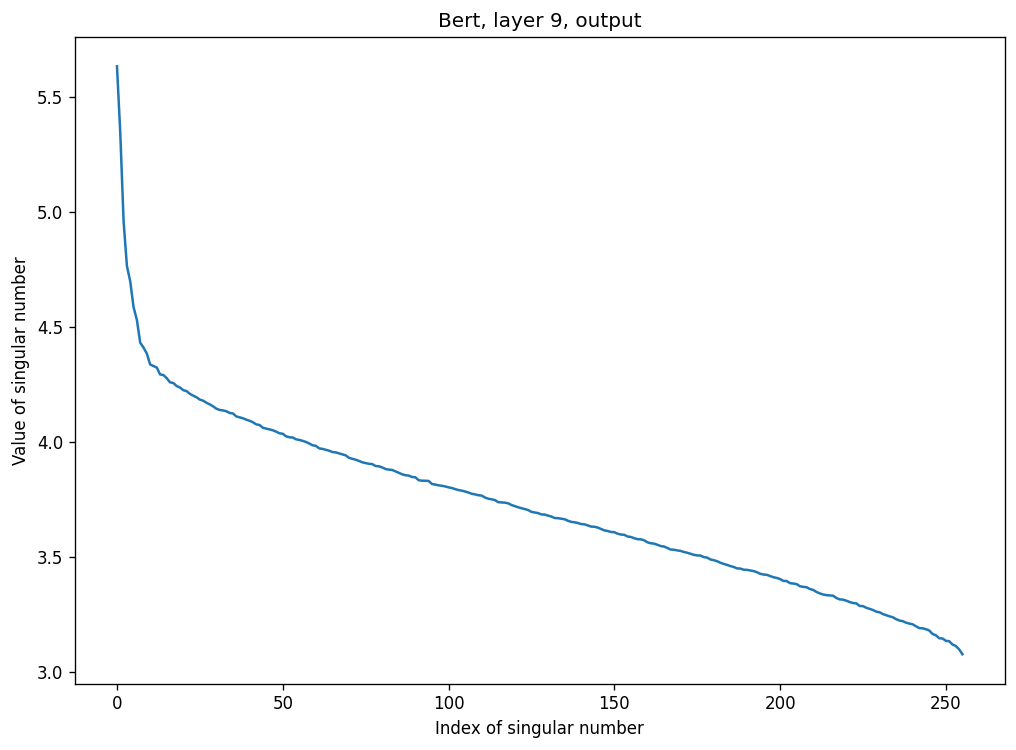

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 10/12 [00:17<00:03,  1.72s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


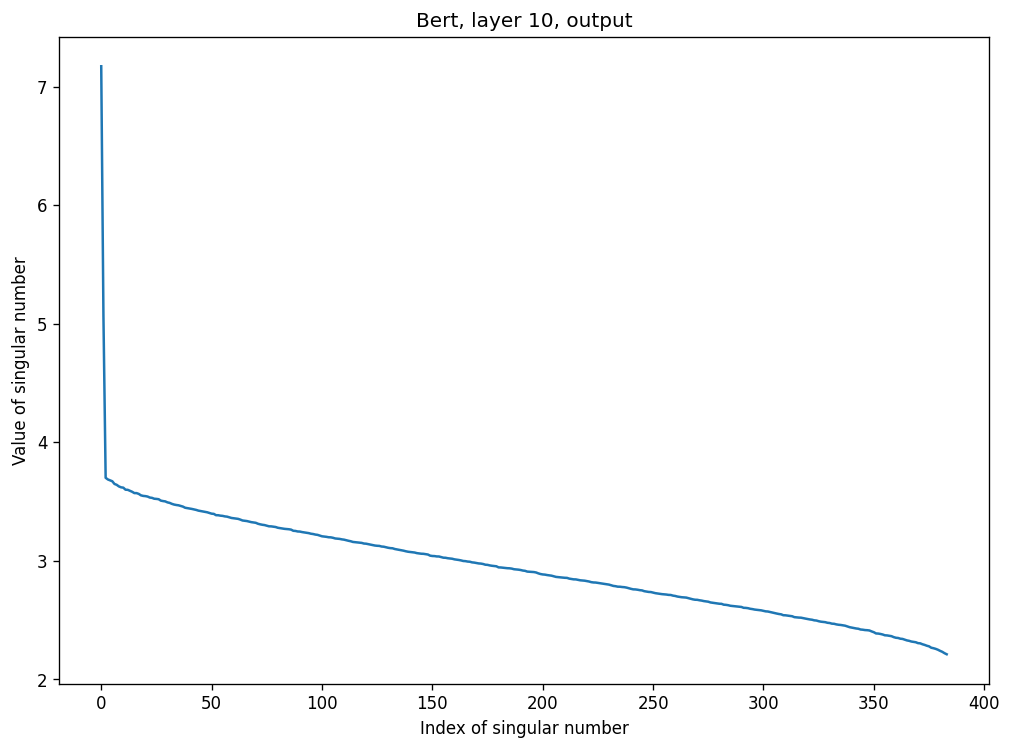

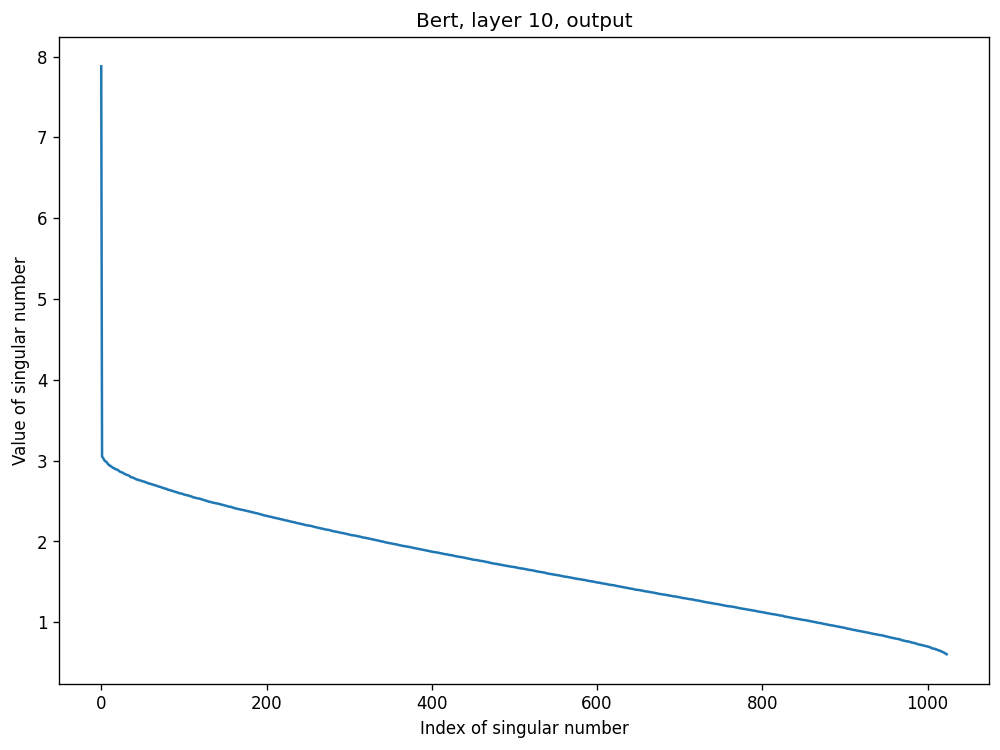

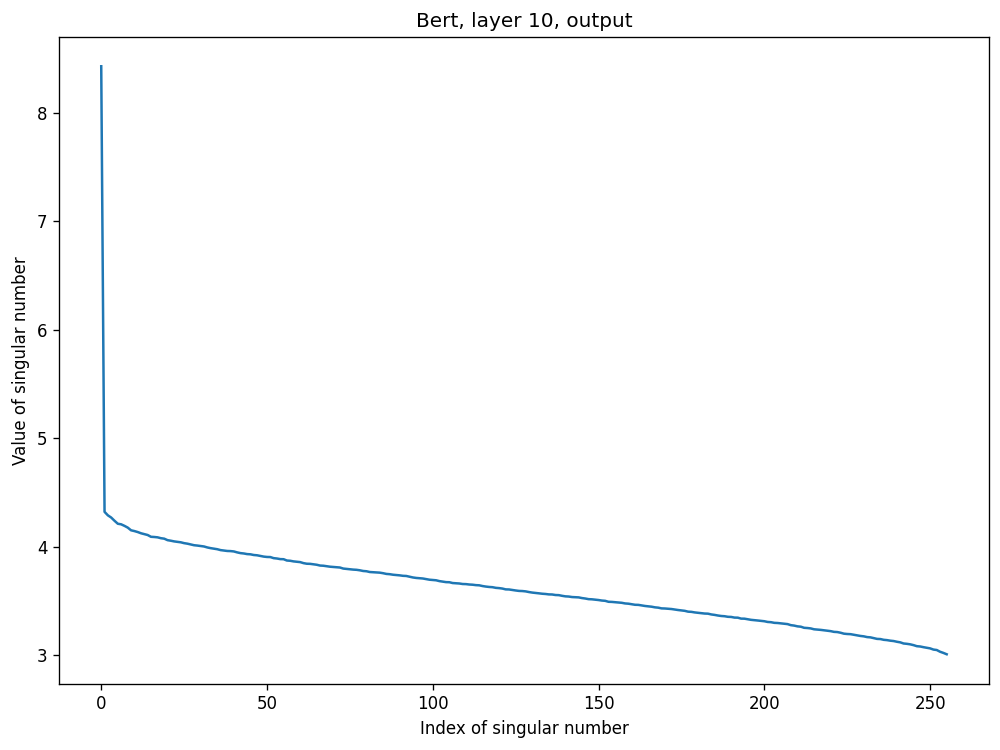

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:18<00:01,  1.70s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


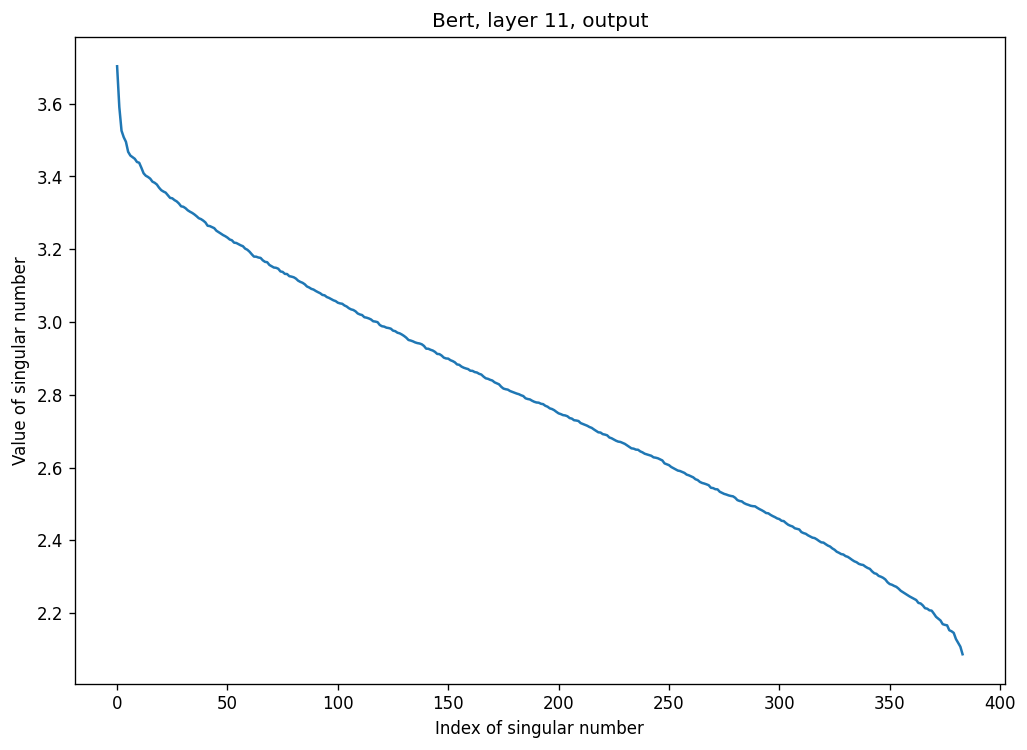

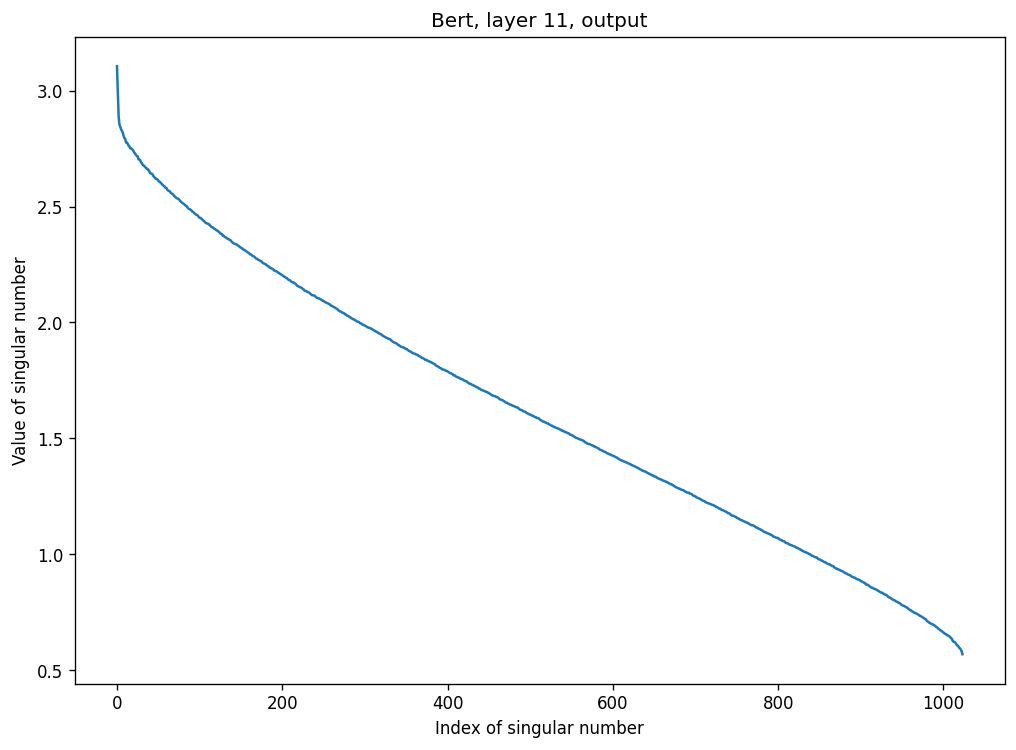

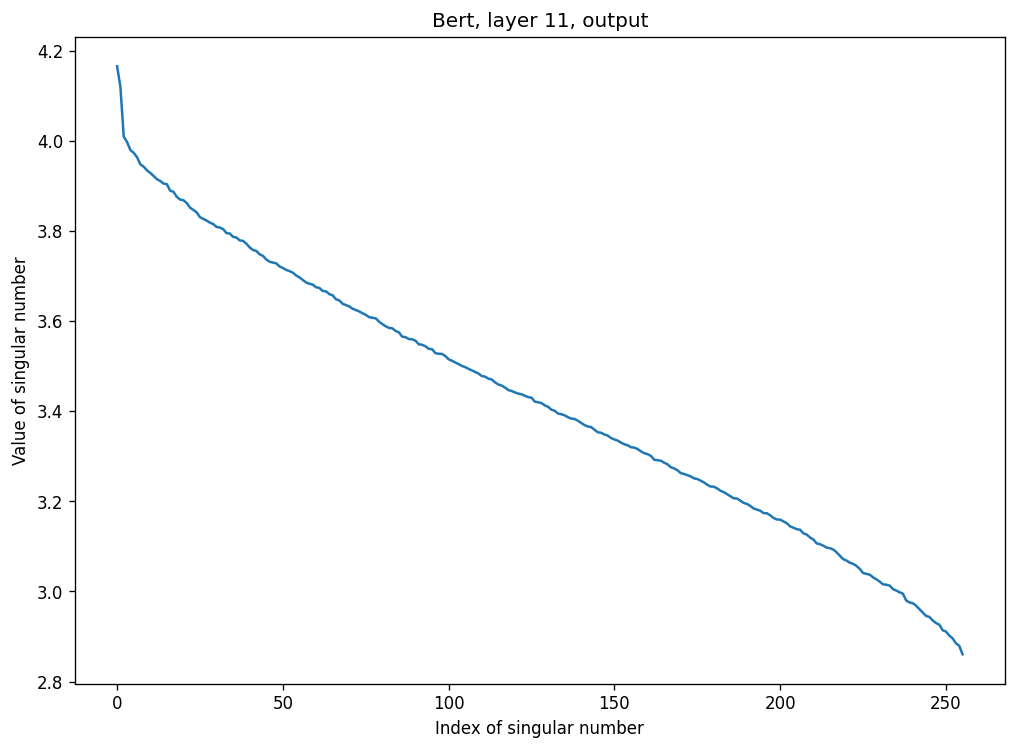

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:20<00:00,  1.71s/it]


In [43]:
ds = make_dataset_bert(bert, "output", layer_to_compress=(3,4,5,7,8))
ds.to_csv("bert_output_dataset.csv", index=False)

In [ ]:
import matplotlib.pyplot as plt
rank = 72  # Uniform TT-rank.
shape = (
(12, 2, 2, 16), # Column dimention.
(32, 3, 2, 16),   # Row dimention.
)

layer = TTCompressedLinear.from_linear(fc_w, shape=shape, rank=rank)

COMPRESS_DIR = "compress"
KEEP_DIR = "keep"

for ind, elem in enumerate(bert.bert.encoder.layer):
    print ("layer ", ind)
    fc_w = bert.bert.encoder.layer[ind].output.dense
    s_values=layer.get_proper_rank(matrix=fc_w.weight.data.T) 
    for elem in s_values:
        plt.plot(elem[:100])
        
        if ind in []:
            plt.savefig(f"images/{}")
        
        plt.show()
    print ("\n")